In [ ]:
#importing all the necessary libraries 
import numpy as np
import pandas as pd  
import imageio
from skimage import img_as_float32 as as_float
from natsort import natsorted
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import multivariate_normal
import cv2
import pickle
from sklearn.metrics import accuracy_score
import time
from skimage import exposure
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold,train_test_split 
from sklearn.metrics import f1_score
plt.gray() #include this to display the gray scalled version of the image using matplotlib
#!pip install split-folders

# Project: Revisiting Background Segmentation Gaussian Mixture Models & Deep Learning
 
Submited by : $Sibusiso \space Mgidi$ student number 1141573 and $Neil \space Fabi\tilde{a}o$ student number 2216748

**Note:** 

`1. This jupyter notebook is considered part 1 of the project, containing code and explanation for the Gauissian Mixture modeling section.`

`2. After each numbered header for example 1.Dataset there will be a dedicated cell with code for the particular task `


## Introduction

In previous labs, we have been helping Quarantino solve his puzzle. In Lab 0, we worked with Tino to create
several ground truth masks which indicated which pixels belonged to the background and which ones belonged
to the puzzle piece.

### 1 Dataset

COMS4036A students only need the dataset that contians cleaned masks and images from Lab 6 provided in puzzle corners 1024x768 v2.zip downloaded from Moodle. The  puzzle images dataset is divide the into training (70%), validation (15%) and test (15%) sets, which you will use for training and analysis in the tasks below. This works out to 34 training images, 7 validation and 7 test images.

- Consider the implications of a dataset this size for the methods below and explain whether or not it will be a problem for each.

Given the size of the dataset, using a gaussian mixture model with at least 30 images to train and to infer with the generated weights (mean and variance) produces considerable results. The main issue however comes to the size of the image and for this project the image size was reduced  to 40% of the original size as seen on the code bellow.

- Explain how you split your data into these sets.

The datasets for the baseline implementation 

In [ ]:
#reading the dataset
path_pairs = list(zip(
natsorted(glob('puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('puzzle_corners_1024x768/masks-1024x768/*.png')),
))
img = np.array([as_float(imageio.imread(ipath)) for ipath, _ in path_pairs])
msk = np.array([as_float(imageio.imread(mpath)) for _, mpath in path_pairs])

print('There are',img.shape[0],'images and',msk.shape[0],'masks')
print('The shape of our data is',img.shape,'and',msk.shape)

In [3]:
SIZE = (768, 1024)

assert img.shape == (48, SIZE[0], SIZE[1], 3)
assert msk.shape == (48, SIZE[0], SIZE[1])

SCALE = 0.40

images = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(img, 'Resizing Images')]
masks1 = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(msk, 'Resizing Masks')]

masks = []#thresholding the mask to 0 and 1 since after rescaling the mask will have different float values
for i in range(len(masks1)):
    mask = cv2.threshold(masks1[i],0,1,cv2.THRESH_BINARY)[1]
    masks.append(mask)
    
print('\n', img[0].shape, '->', images[0].shape)

Resizing Masks: 100%|██████████| 48/48 [00:00<00:00, 1653.93it/s]


 (768, 1024, 3) -> (307, 410, 3)


#### 1.1 Splitting the dataset

###### 1.1.1 Baseline split

In [4]:
#source: https://www.quora.com/How-can-I-split-my-image-datasets-into-training-validation-and-testing-sets-for-Neural-Network-CNN-in-python
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

 

VALIDATION_needed = True 
def train_test_valid_split(all_X, all_Y,PERC_TRAIN = 0.65,PERC_VALIDATION = 0.14,PERC_TEST = 0.13): 
    '''
    returs the desired data split ( 34 training images, 7 validation and 7 test images)
    
    params: 
    - all_X image data
    - all_Y mask or ground truth data
    - PERC_VALIDATION percentage for validation data
    - PERC_TEST percentage for testing data
    - PERC_TRAIN percentage for training data
    
    '''
    left_X, valid_X, left_y, valid_y = train_test_split(all_X, all_Y, test_size=PERC_VALIDATION) 
    train_X, test_X, train_y, test_y = train_test_split(left_X, left_y, test_size=PERC_TEST / (PERC_TEST + PERC_TRAIN)) 
    return test_X, test_y, train_X, train_y, valid_X, valid_y 
 
if VALIDATION_needed: 
    test_X, test_y, train_X, train_y, valid_X, valid_y = train_test_valid_split(images, masks) 
else: 
    train_X, test_X, train_y, test_y = train_test_split(images, masks) 

In [5]:
print('After data split have:',len(train_X),
      'training images',len(valid_X),
      'validation and',len(test_X),'test images')

After data split have: 34 training images 7 validation and 7 test images


<img src="im/traintest.png" alt="Where is the image ?" width="670"/>

### 2 Gaussian Mixture Models


In statistics, an expectation–maximization (EM) algorithm is an iterative method to that allows to find the maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models. The model depends on hiden latent variables and the EM iteration alternates between performing expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step.[Oran Looney,2019](http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/).

<img src="./im/gmm.gif" alt="Where is the image ?" width="200" heigth="200"/>

In [6]:
class GMM_scratch:
    '''
        This class is the implementation of the Gaussian Mixture Models for the project
        Inspiration for this function came from sklearn.mixture.GaussianMixture and other sources listed bellow
        
        params: 
        data - the image data to train in the EM step of the GMM
        numb_components - the number of clusters to train the GMM
        init_strategy - method to initialize the means of the GMM. 0 is the normal initialization method
        
        
        sources :
        https://github.com/ScienceKot/mysklearn/blob/master/Gaussian%20Mixture%20Models/GMM.py
        https://stackoverflow.com/questions/44913009/initialize-gmm-using-sklearn-python
        https://github.com/SeoHyeong/GMM_image-segmentation/blob/master/GMM_image%20segmentation.ipynb
    '''
    
    
    def __init__(self, data, numb_components,init_strategy):#Step1 initialization of the main variables
        
        self.valuesforplot = []
        self.data = data
        self.numb_components = numb_components
        
        self.H = self.data.shape[1]#D#need to understant this point
        self.W = self.data.shape[0]#n#need to understant this point
        
        self.lamda = np.ones((self.numb_components))/self.numb_components
        self.means = np.zeros((self.numb_components,self.H))
        #create distances variable
        if(init_strategy == 0):#random initialization
            for i in range(self.numb_components):
                soma = random.choice(self.data)
                self.means[i] = soma
            
        else:#kmeans initialization
            from sklearn.cluster import KMeans
            km = KMeans(numb_components).fit(self.data)
            self.means = km.cluster_centers_
            
        self.covariance = np.zeros((self.numb_components,self.H,self.H))#creating the covariance array with the necessary dimations 
        self.covariance[:] = np.cov(self.data.T)#array that holds all the covariance information 

        self.responsavel = np.zeros((self.W, self.numb_components))#responsavel is simply responsability array given the number of channels and components in the array
        
    #-------------------------------------------Norm-Step------------------------------------------------------------     
    def normalvariant(self):
        '''
        this is used to calculate the normal distribution, saw this on sklearn GMM class 
        '''
        numb_components = self.numb_components
        self.normal = []
        for i in range(numb_components):
            self.normal.append(multivariate_normal(mean=self.means[i], cov=self.covariance[i]))
    #-------------------------------------------E-Step-------------------------------------------------------------- 
    def Expectation(self):#need to understant this section
        numb_components = self.numb_components
        self.normalvariant()
        
        for i, points in enumerate(self.data):
            for j in range(numb_components):
                
                self.responsavel[i,j] = self.lamda[j]*self.normal[j].pdf(points)#canculating the responsabilities 
            self.responsavel[i,:] /= self.responsavel[i, :].sum()#using the points from the normal distribution 
                                                                #of the the feature vector 
            
    #-------------------------------------------M-Step---------------------------------------------------------------
    def Maximization(self):#need to understant this section
        numb_components = self.numb_components

        responsavel_sum = self.responsavel.sum(0)
        
        self.lamda = responsavel_sum/float(self.responsavel.sum())

        for i in range(self.numb_components):
            self.means[i] = self.responsavel[:,i].dot(self.data)/responsavel_sum[i]
            
        for i in range(self.numb_components):
            temp = np.zeros((self.H, self.H))
            for j in range(self.W):
                t = self.data[j, :] - self.means[i]
                temp += self.responsavel[j,i]*np.outer(t,t)#creating the identity matrix to be used for calculating
            self.covariance[i] = temp/responsavel_sum[i]#the covariance matrix to avoid singularity issue
            
        #reseting the covarirance and mean depicted in the link bellow just in case extra bugs arise
        #https://stats.stackexchange.com/questions/219302/singularity-issues-in-gaussian-mixture-model
        if(np.isnan(self.covariance[i]).any()== True):
            self.covariance[i] = np.cov(self.data.T)#calculate the covariance again 
                
        for i in range(self.numb_components):
            soma = random.choice(self.data)
            self.means[i] = soma#random mean
            
    #-------------------------------------------Train or fit Step----------------------------------------------------- 
    def fit(self, tolerance=0.01, max_epoch=35):
        distance = tolerance
        epoch = 0
        while ((distance >= tolerance) and (epoch != max_epoch)):
            old_means = self.means.copy()
            self.Expectation()
            self.Maximization()
            distance = np.linalg.norm(old_means - self.means)
            print(epoch, distance)
            epoch += 1
            array = np.array([epoch,distance])
            self.valuesforplot.append(array)
   #-------------------------------------------Likelihood-Step--------------------------------------------------------
    def Proba(self,image):
    
        Probabilities = np.zeros((image.shape[:-1]))
        numb_components = self.numb_components
        for i in range(numb_components):
            Probabilities += self.lamda[i] * multivariate_normal(mean=self.means[i], cov=self.covariance[i]).pdf(image)
        return Probabilities 

### 3 Feature vector

A feature vector can be considered a collection of features (important characteristic of the image being studied) which you extracted and form of matrix. For this project the following feature sets will be utilized:

1. RGB pixel value
2. RGB+Difference of Gaussian
3. One other feature set from the previous labs that performed well.

The function bellow returns the puzzle and background pixels for this project, conversely the following sections will make use of the function bellow.

In [7]:
def pixels(image, mask):
    '''
    Return puzzle and background pixels
    params: 
    - image array containing all the image
    - mask array containing all the mask 
    '''
    puzzle = image[mask == 1]
    background = image[mask == 0]
    return puzzle, background
    
def priors(mask): 
    '''
    Return the prior of the mask
    params: 
    - mask array containing all the mask             
    '''    
    puzzle = np.sum(mask == 1)
    background = np.sum(mask == 0)
    prior = puzzle/(puzzle + background)
    return prior

def Puzzle_background_Pixels_one(num_images,img,mks):
    '''
    Return the puzzle and background pixels plus the prior of the mask to be used later in the project
    params: 
    - num_images it specifies the number of images we wish to extract information from
    - img array containing all the image data
    - mk array containing all the mask data
    
    altought there are may ways to do this this source to concatenate feature vectors as used in this project:
    https://www.researchgate.net/post/How_to_concatenate_feature_vectors_in_Python
    ''' 
    prior = 0
    for i in range(num_images):
        image, mask = (img[i], mks[i])
        if(i == 0):
            puzzle_pixels, background_pixels = pixels(image, mask)
            prior = priors(mask)
        else:
            curr_puzzle_pixels, curr_background_pixels = pixels(image, mask)
            puzzle_pixels = np.vstack((puzzle_pixels, curr_puzzle_pixels))
            background_pixels = np.vstack((background_pixels, curr_background_pixels))
            prior += priors(mask)
    return puzzle_pixels, background_pixels,prior

print('For the mask we have :{}'.format(np.unique(masks[0])) )
print('Number of white or puzzle pixels :{}'.format(np.sum(masks[0] == 1)))#puzzle pixel for image 1
print('Number of black or background pixels :{}'.format(np.sum(masks[0] == 0))) #background pixel for image 1

#helper function to display images using matplotlib.pyplot.imshow 
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        plt_idx = i+1
        plt.subplot(4, 2, plt_idx)    
        plt.imshow(img)
        #plt.grid(b=None)
    plt.show()

#the code bellow retrieves the information for puzzle, background and prior for 34 images
puzzle_pixel_RGB, background_pixel_RGB, prior_RGB = Puzzle_background_Pixels_one(34,train_X,train_y)

For the mask we have :[0. 1.]
Number of white or puzzle pixels :32400
Number of black or background pixels :93470


### 3.1 Testing convergence parameters

In [ ]:
'''
At each GMM running cell there is a pickle that is saved on the machine and is stored in the foldfer
that this code is located. This code takes long to run depending of the number of components 👍🏾
'''
number_of_components=4
gmms_puzzle = []
gmms_background = []
val = 1

print('The number of gaussian for RGB using puzzle pixels is:',number_of_components,"with convergence",val)
pkl = open("gmm_puzzle-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(puzzle_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_puzzle.append(gmm)
pkl.close()
print('end of convergence puzzle')

print('The number of gaussian for RGB using background pixels is:',number_of_components,"with convergence",val)
pkl = open("gmm_background-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(background_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_background.append(gmm)
pkl.close()
print('end of convergence background')

In [ ]:
val = 0.1
gmms_puzzle = []
print('The number of gaussian for RGB using puzzle pixels is:',number_of_components,"with convergence",val)
pkl = open("gmm_puzzle-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(puzzle_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_puzzle.append(gmm)
pkl.close()
print('end of convergence puzzle')

gmms_background = []
print('The number of gaussian for RGB using background pixels is:',number_of_components,"with convergence",val)
pkl = open("gmm_background-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(background_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_background.append(gmm)
pkl.close()
print('end of convergence background')

In [ ]:
val = 0.03
gmms_puzzle = []
print('The number of gaussian for RGB using puzzle pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_puzzle-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(puzzle_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_puzzle.append(gmm)
pkl.close()
print('end of convergence puzzle')

gmms_background = []
print('The number of gaussian for RGB using background pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_background-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(background_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_background.append(gmm)
pkl.close()
print('end of convergence background')

In [ ]:
val = 0.01
gmms_puzzle = []
print('The number of gaussian for RGB using puzzle pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_puzzle-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(puzzle_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_puzzle.append(gmm)
pkl.close()
print('end of convergence puzzle')

gmms_background = []
print('The number of gaussian for RGB using background pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_background-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(background_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=20)
pickle.dump(gmm, pkl)
gmms_background.append(gmm)
pkl.close()
print('end of convergence background')

In [ ]:
val = 0.001
gmms_puzzle = []
print('The number of gaussian for RGB using puzzle pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_puzzle-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(puzzle_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=25)
pickle.dump(gmm, pkl)
gmms_puzzle.append(gmm)
pkl.close()
print('end of convergence puzzle')

gmms_background = []
print('The number of gaussian for RGB using background pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_background-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(background_pixel_RGB, number_of_components,0)#GMM with random clustered centers
gmm.fit(tolerance=val, max_epoch=25)
pickle.dump(gmm, pkl)
gmms_background.append(gmm)
pkl.close()
print('end of convergence background')

In [ ]:
val = 0.0001
gmms_puzzle = []
print('The number of gaussian for RGB using puzzle pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_puzzle-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(puzzle_pixel_RGB, number_of_components,1)#GMM with KMEANS clustered centers
gmm.fit(tolerance=val, max_epoch=45)
pickle.dump(gmm, pkl)
gmms_puzzle.append(gmm)
pkl.close()
print('end of convergence puzzle')

gmms_background = []
print('The number of gaussian for RGB using background pixels is:',number_of_components,"with convergence",val)
pkl = open("tolerance/gmm_background-RGB-"+str(i)+"-tolerance"+str(val)+".pickle","wb")
gmm = GMM_scratch(background_pixel_RGB, number_of_components,1)#GMM with KMEANS clustered centers
gmm.fit(tolerance=val, max_epoch=35)
pickle.dump(gmm, pkl)
gmms_background.append(gmm)
pkl.close()
print('end of convergence background')

### 4.1 RGB pixel value (trainning section)
Retreiving RGB pixel values in image and creating the first feature vector of the lab.

In [ ]:
'''
retrieving the puzzle and background pixels as well as the prior for the RGB pixels using 34 images
you can select the number of components you wish to start and end-1
'''
puzzle_pixel_RGB, background_pixel_RGB, prior_RGB = Puzzle_background_Pixels_one(34,train_X,train_y)
gmms_puzzle = []
gmms_background = []

start_component = 1
end_component = 3

In [ ]:
for i in range(start_component, end_component):
    print('The number of gaussian for RGB using puzzle pixels is now:',i)
    pkl = open("test/gmm_puzzle-RGB-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(puzzle_pixel_RGB, i,0)#GMM with sklearn clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_puzzle.append(gmm)
    pkl.close()

In [ ]:
for i in range(start_component, end_component):
    print('The number of gaussian for RGB using background pixels is now :',i)
    pkl = open("test/gmm_background-RGB-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(background_pixel_RGB, i,0)#GMM with sklearn clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_background.append(gmm)
    pkl.close()

#### GMM with kmeans initialized means

In [ ]:
gmms_puzzle = []
gmms_background = []

for i in range(start_component, end_component):
    print('The number of gaussian for RGB using puzzle pixels is now:',i)
    pkl = open("test/gmm_puzzle-RGBKmeans-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(puzzle_pixel_RGB, i,1)#GMM with sklearn clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_puzzle.append(gmm)
    pkl.close()

In [ ]:
for i in range(start_component, end_component):
    print('The number of gaussian for RGB using background pixels is now :',i)
    pkl = open("test/gmm_background-RGBKmeans-final"+str(i)+".pickle","wb")
    gmm = GMM_scratch(background_pixel_RGB, i,1)#GMM with sklearn clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_background.append(gmm)
    pkl.close()

### 4.2 RGB+Difference of Gaussian

Retreiving RGB+DOG pixel values in image and creating the second feature vector of the lab.

In [10]:
def DoG(size,sig,k):
    s = int(size/2)
    kernel = np.zeros( (size,size),np.float32)
    
    for x in range(-s,s-1):
        for y in range(-s,s-1):
            part1 = (1/(2*np.pi*sig**2))
            part2 = np.exp(-1*((x**2+y**2))/(2*sig**2) ) 
            part3 = (1/(2*np.pi*k**2*sig**2))*np.exp(-1*((x**2 + y**2))/(2*k**2*sig**2))
            
            kernel[x+s,y+s] = part1*part2-part3
            
    return kernel

train_X_DoG = []
for i in range(len(train_X)):
    test_DoG = cv2.filter2D(train_X[i],-1,DoG(49,3,2))
    train_X_DoG.append(exposure.rescale_intensity(test_DoG))
    
puzzle_pixel_DOG, background_pixel_DOG, prior_DOG = Puzzle_background_Pixels_one(30,train_X_DoG,train_y)

#feature vector for RGB DOG
puzzle_pixel_RGBDOG = np.vstack((puzzle_pixel_RGB, puzzle_pixel_DOG))
background_pixel_RGBDOG = np.vstack((background_pixel_RGB, background_pixel_DOG))
prior_RGBDOG = prior_RGB + prior_DOG

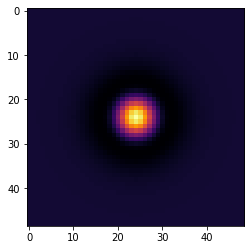

In [11]:
plt.imshow(DoG(49,3,2),cmap='inferno')
plt.show()

In [ ]:
gmms_puzzle = []
gmms_background = []
for i in range(start_component,end_component):
    print('The number of gaussian for RGBDOG using puzzle pixels is now:',i)
    pkl = open("test/gmm_puzzle-RGBDOG-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(puzzle_pixel_RGBDOG, i,0)#GMM with random clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_puzzle.append(gmm)
    pkl.close()

In [ ]:
for i in range(start_component,end_component):
    print('The number of gaussian for RGBDOG using background pixels is now :',i)
    pkl = open("test/gmm_background-RGBDOG-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(background_pixel_RGBDOG, i,0)#GMM with random clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_background.append(gmm)
    pkl.close()

### 4.3 One other feature set from the previous labs that performed well.

The other feature set that will be used from the previous lab will be the HSV (hue, saturation, value) color space by itself and lastly a combination of HSV and LBP

In [12]:
'''
We need to change the images to HSV in order to execute this section of the project. Simply because if we are
infering using HSV color space our training test and validation images all need to be converted to 
the same color band
'''
train_X_HSV = []
test_X_HSV = []
valid_X_HSV = []

for i in range(len(train_X)):
    train_HSV = cv2.cvtColor(train_X[i], cv2.COLOR_RGB2HSV)
    train_X_HSV.append(train_HSV)
    
for i in range(len(test_X)):
    test_HSV = cv2.cvtColor(test_X[i], cv2.COLOR_RGB2HSV)
    test_X_HSV.append(test_HSV)
    
for i in range(len(valid_X)):
    val_HSV = cv2.cvtColor(valid_X[i], cv2.COLOR_RGB2HSV)
    valid_X_HSV.append(val_HSV)
    
puzzle_pixe_HSV, background_pixel_HSV, prior_HSV = Puzzle_background_Pixels_one(30,train_X_HSV,train_y)

#feature vector
puzzle_pixel_HSVDOG = np.vstack((puzzle_pixe_HSV, puzzle_pixel_DOG))
background_pixel_HSVDOG = np.vstack((background_pixel_HSV, background_pixel_DOG))
prior_HSVDOG = prior_DOG + prior_HSV

In [ ]:
gmms_puzzle = []
gmms_background = []

for i in range(start_component,end_component):
    print('The number of gaussian for HSVDOG using puzzle pixels is now:',i)
    pkl = open("test/gmm_puzzle-HSVDOG-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(puzzle_pixel_HSVDOG, i,0)#GMM with random clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_puzzle.append(gmm)
    pkl.close()

In [ ]:
'''
if this cell runs into devision by zero is fine the turn around was to infer only using the model generated 
by the puzzle pixels section
'''
gmms_background = []
for i in range(start_component,end_component):
    print('The number of gaussian for HSVDOGkmeans using background pixels is now :',i)
    pkl = open("test/gmm_background-HSVDOGkmeans-"+str(i)+".pickle","wb")
    gmm = GMM_scratch(background_pixel_HSVDOG, i,0)#GMM with random clustered centers
    gmm.fit()
    pickle.dump(gmm, pkl)
    gmms_background.append(gmm)
    pkl.close()

### 5 Inference and Metrics 
The section bellow contains the method used infer the models throught this notebook, in addition it also presents the metrics used which are the following :
- Confusion matrix 
- cohens kappa score
- intersection over union 

In [13]:
def Metrics_CM_CK_IOU(validation_image,index,images):
    '''
    Return the confusion matrix, the cohens kappa score and IOU (intersection over union)
    for only 4 probable masks.
    
    params: 
    - validation_image is the array containing the testing images
    - index of the image that was used to generate the probable images
    - image array containing all the image provided by the GMM (probable maks)
    
    '''
    
    main_mask = validation_image[index]
    main_mask = main_mask.flatten()

    Prob_mask1 = images[0]
    Prob_mask1 = Prob_mask1.flatten()

    Prob_mask2 = images[1]
    Prob_mask2 = Prob_mask2.flatten()

    Prob_mask3 = images[2]
    Prob_mask3 = Prob_mask3.flatten()
    
    Prob_mask4 = images[3]
    Prob_mask4 = Prob_mask4.flatten()

    model1 = confusion_matrix(main_mask, Prob_mask1)
    print('This is the confusion matrix for mask',index,'and GMM 2: \n',model1)

    model2 = confusion_matrix(main_mask, Prob_mask2)
    print('This is the confusion matrix for mask',index,'and GMM 3: \n',model2)

    model3 = confusion_matrix(main_mask, Prob_mask3)
    print('This is the confusion matrix for mask',index,'and GMM 4: \n',model3)
    
    model4 = confusion_matrix(main_mask, Prob_mask4)
    print('This is the confusion matrix for mask',index,'and GMM 5: \n',model4)

    print('\n')
    
    cohens_kappa1 = cohen_kappa_score(main_mask, Prob_mask1)
    print('This is the cohens kappa score for mask',index,'and GMM 2:',cohens_kappa1)

    cohens_kappa2 = cohen_kappa_score(main_mask, Prob_mask2)
    print('This is the cohens kappa score for mask',index,'and GMM 3: ',cohens_kappa2)

    cohens_kappa3 = cohen_kappa_score(main_mask, Prob_mask3)
    print('This is the cohens kappa score for mask',index,'and GMM 4: ',cohens_kappa3)
    
    cohens_kappa4 = cohen_kappa_score(main_mask, Prob_mask4)
    print('This is the cohens kappa score for mask',index,'and GMM 5:',cohens_kappa4)
    
    CK_final = [cohens_kappa1,cohens_kappa2,cohens_kappa3,cohens_kappa4]
    print('\n')
    
    overlap = main_mask*Prob_mask1 # Logical AND
    union = main_mask + Prob_mask1# Logical OR
    IOU1 = overlap.sum()/float(union.sum())           
    print('The intersection over union of the predicted GMM 2 and mask',index,': ',IOU1)

    overlap = main_mask*Prob_mask2 
    union = main_mask + Prob_mask2 # Logical OR
    IOU2 = overlap.sum()/float(union.sum())      
    print('The intersection over union of the predicted GMM 3 and mask',index,': ',IOU2) 
    
    overlap = main_mask*Prob_mask3 # Logical AND
    union = main_mask + Prob_mask3 # Logical OR
    IOU3 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 4 and mask',index,': ',IOU3)
    
    overlap = main_mask*Prob_mask4 # Logical AND
    union = main_mask + Prob_mask4 # Logical OR
    IOU4 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 5 and mask',index,': ',IOU4)
    
    #-----------------------------------------------------------------------------------------------------------
    print('\n')
    print('---------------------------------Present Best Model----------------------------------------------------')
    CFM_final = [model1,model2,model3,model4]
    my_scores2 = [IOU1,IOU2,IOU3,IOU4]
    indexmax = my_scores2.index(max(my_scores2))
    
    print('This is the confusion matrix for the best model')
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(CFM_final[indexmax], vmin=-1, vmax=1, center=0,cmap="Blues",square=True, annot=True, fmt=".0f")
    ax.set_ylim([0,2])
    
    ax.set_xticklabels(['Positive','Negative']) # set the labels to display at those ticks
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0,horizontalalignment='right');
    
    ax.set_yticklabels(['Negative','Positive']) # set the labels to display at those ticks
    ax.set_yticklabels(ax.get_yticklabels(),rotation=90,horizontalalignment='right');
    
    print('The best cohens kappa score is',CK_final[indexmax])
    print('The best IOU is',my_scores2[indexmax])
    
    print('This is the confusion matrix for the best model')
    return indexmax

In [14]:
def Metrics_CM_CK_IOU_nine(validation_image,index,images):
    '''
    Return the confusion matrix, the cohens kappa score and IOU (intersection over union)
    for only 4 probable masks.
    
    params: 
    - validation_image is the array containing the testing images
    - index of the image that was used to generate the probable images
    - image array containing all the image provided by the GMM (probable maks)
    
    '''
    
    main_mask = validation_image[index]
    main_mask = main_mask.flatten()

    Prob_mask1 = images[0]
    Prob_mask1 = Prob_mask1.flatten()

    Prob_mask2 = images[1]
    Prob_mask2 = Prob_mask2.flatten()

    Prob_mask3 = images[2]
    Prob_mask3 = Prob_mask3.flatten()
    
    Prob_mask4 = images[3]
    Prob_mask4 = Prob_mask4.flatten()
    
    Prob_mask5 = images[4]
    Prob_mask5 = Prob_mask5.flatten()
    
    Prob_mask6 = images[5]
    Prob_mask6 = Prob_mask6.flatten()
    
    Prob_mask7 = images[6]
    Prob_mask7 = Prob_mask7.flatten()
    
    Prob_mask8 = images[7]
    Prob_mask8 = Prob_mask8.flatten()
    
    model1 = confusion_matrix(main_mask, Prob_mask1)
    print('This is the confusion matrix for mask',index,'and GMM mask 2: \n',model1)

    model2 = confusion_matrix(main_mask, Prob_mask2)
    print('This is the confusion matrix for mask',index,'and GMM mask 3: \n',model2)

    model3 = confusion_matrix(main_mask, Prob_mask3)
    print('This is the confusion matrix for mask',index,'and GMM mask 4: \n',model3)
    
    model4 = confusion_matrix(main_mask, Prob_mask4)
    print('This is the confusion matrix for mask',index,'and GMM mask 5: \n',model4)
    
    model5 = confusion_matrix(main_mask, Prob_mask5)
    print('This is the confusion matrix for mask',index,'and GMM mask 6: \n',model5)
    
    model6 = confusion_matrix(main_mask, Prob_mask6)
    print('This is the confusion matrix for mask',index,'and GMM mask 7: \n',model6)
    
    model7 = confusion_matrix(main_mask, Prob_mask7)
    print('This is the confusion matrix for mask',index,'and GMM mask 8: \n',model7)
    
    model8 = confusion_matrix(main_mask, Prob_mask8)
    print('This is the confusion matrix for mask',index,'and GMM mask 9: \n',model8)
 
    print('\n')
    
    cohens_kappa1 = cohen_kappa_score(main_mask, Prob_mask1)
    print('This is the cohens kappa score for mask',index,'and GMM mask 2:',cohens_kappa1)

    cohens_kappa2 = cohen_kappa_score(main_mask, Prob_mask2)
    print('This is the cohens kappa score for mask',index,'and GMM mask 3: ',cohens_kappa2)

    cohens_kappa3 = cohen_kappa_score(main_mask, Prob_mask3)
    print('This is the cohens kappa score for mask',index,'and GMM mask 4: ',cohens_kappa3)
    
    cohens_kappa4 = cohen_kappa_score(main_mask, Prob_mask4)
    print('This is the cohens kappa score for mask',index,'and GMM mask 5:',cohens_kappa4)
    
    cohens_kappa5 = cohen_kappa_score(main_mask, Prob_mask5)
    print('This is the cohens kappa score for mask',index,'and GMM mask 6:',cohens_kappa5)
    
    cohens_kappa6 = cohen_kappa_score(main_mask, Prob_mask6)
    print('This is the cohens kappa score for mask',index,'and GMM mask 7:',cohens_kappa6)
    
    cohens_kappa7 = cohen_kappa_score(main_mask, Prob_mask7)
    print('This is the cohens kappa score for mask',index,'and GMM mask 8:',cohens_kappa7)
    
    cohens_kappa8 = cohen_kappa_score(main_mask, Prob_mask8)
    print('This is the cohens kappa score for mask',index,'and GMM mask 9:',cohens_kappa8)
    
    CK_final = [cohens_kappa1,cohens_kappa2,cohens_kappa3,cohens_kappa4,cohens_kappa5,cohens_kappa6,cohens_kappa7,cohens_kappa8]
    print('\n')
    
    overlap = main_mask*Prob_mask1 # Logical AND
    union = main_mask + Prob_mask1# Logical OR
    IOU1 = overlap.sum()/float(union.sum())           
    print('The intersection over union of the predicted GMM 2 and mask',index,': ',IOU1)

    overlap = main_mask*Prob_mask2 
    union = main_mask + Prob_mask2 # Logical OR
    IOU2 = overlap.sum()/float(union.sum())      
    print('The intersection over union of the predicted GMM 3 and mask',index,': ',IOU2) 
    
    overlap = main_mask*Prob_mask3 # Logical AND
    union = main_mask + Prob_mask3 # Logical OR
    IOU3 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 4 and mask',index,': ',IOU3)
    
    overlap = main_mask*Prob_mask4 # Logical AND
    union = main_mask + Prob_mask4 # Logical OR
    IOU4 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 5 and mask',index,': ',IOU4)
    
    overlap = main_mask*Prob_mask5 # Logical AND
    union = main_mask + Prob_mask5 # Logical OR
    IOU5 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 6 and mask',index,': ',IOU5)
    
    overlap = main_mask*Prob_mask6 # Logical AND
    union = main_mask + Prob_mask6 # Logical OR
    IOU6 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 7 and mask',index,': ',IOU6)
    
    
    overlap = main_mask*Prob_mask7 # Logical AND
    union = main_mask + Prob_mask7 # Logical OR
    IOU7 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 8 and mask',index,': ',IOU7)
    
    
    overlap = main_mask*Prob_mask8 # Logical AND
    union = main_mask + Prob_mask8 # Logical OR
    IOU8 = overlap.sum()/float(union.sum())         
    print('The intersection over union of the predicted GMM 9 and mask',index,': ',IOU8)
    
    #-----------------------------------------------------------------------------------------------------------
    print('\n')
    print('---------------------------------Present Best Model----------------------------------------------------')
    CFM_final = [model1,model2,model3,model4,model5,model6,model7]
    my_scores2 = [IOU1,IOU2,IOU3,IOU4,IOU5,IOU6,IOU7]
    indexmax = my_scores2.index(max(my_scores2))
    
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(CFM_final[indexmax], vmin=-1, vmax=1, center=0,cmap="Blues",square=True, annot=True, fmt=".0f")
    ax.set_ylim([0,2])
    
    ax.set_xticklabels(['Positive','Negative']) # set the labels to display at those ticks
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0,horizontalalignment='right');
    
    ax.set_yticklabels(['Negative','Positive']) # set the labels to display at those ticks
    ax.set_yticklabels(ax.get_yticklabels(),rotation=90,horizontalalignment='right');
    
    print('The best cohens kappa score is',CK_final[indexmax])
    print('The best IOU is',my_scores2[indexmax])
    
    print('This is the confusion matrix for the best model')
    return indexmax

### 5.1 Plots of convergence from the above implementations 

Before starting this section it is best to remember the results achieved from the inference using only a normal distribution as depicted on the images bellow:


<img src="./im/Inference_hsvnormal.png" alt="Where is the image ?" width="400" heigth="200"/>

<img src="./im/inference_rgbnormal.png" alt="Where is the image ?" width="400" heigth="200"/>

The values used during the plot of this graphs were achieved using convergence of 0.0001 and the plots were done manually using the difference of means that are displayed after each function starts and finishes converging. The plots present data for convergence of puzzle pixels since this feature vector takes more time to compute.

### Understanding the best tolerance value to use

By tolerance the coder refers to epsilon or convergence parameter


In [55]:
images_tolerance = []
X_raw = np.asarray(images)#make this an array to locate the image that was used for inference 
Y_raw = np.asarray(masks)# using normal distribution 

def tolerance_test(pickle_puzzle,pickle_background):
    
    pickle_off0 = pickle_puzzle
    gmm_puzzle = pickle.load(pickle_off0) 

    pickle_off1 = pickle_background
    gmm_background = pickle.load(pickle_off1)

    index = 21
    image, mask = (X_raw[index], Y_raw[index])
    ##### The inference as specified in the question using the background and the puzzle pixels gmm
    likelihood1 = gmm_background.Proba(image) #probability of being background
    likelihood2 = gmm_puzzle.Proba(image) #probability of being foreground
    ##########  
    prior1 = prior_RGB
    prior2 = 1 - prior_RGB 
    #########   
    foreground_prior = prior2 * likelihood2
    Background_prior = foreground_prior + (prior1 * likelihood1)
    #########   
    prob = foreground_prior/Background_prior   
    ####### 
    prob[prob>0.5] = 1
    prob[prob<0.5] = 0

    return(prob)


pickle_puzzle1 = open("tolerance/gmm_puzzle-RGB-47-tolerance1.pickle","rb")
pickle_background1 = open("tolerance/gmm_background-RGB-47-tolerance1.pickle","rb")
images_tolerance.append(tolerance_test(pickle_puzzle1,pickle_background1)) 

pickle_puzzle1 = open("tolerance/gmm_puzzle-RGB-47-tolerance0.03.pickle","rb")
pickle_background1 = open("tolerance/gmm_background-RGB-47-tolerance0.03.pickle","rb")
images_tolerance.append(tolerance_test(pickle_puzzle1,pickle_background1)) 

pickle_puzzle1 = open("tolerance/gmm_puzzle-RGB-47-tolerance0.01.pickle","rb")
pickle_background1 = open("tolerance/gmm_background-RGB-47-tolerance0.01.pickle","rb")
images_tolerance.append(tolerance_test(pickle_puzzle1,pickle_background1)) 

pickle_puzzle1 = open("tolerance/gmm_puzzle-RGB-47-tolerance0.001.pickle","rb")
pickle_background1 = open("tolerance/gmm_background-RGB-47-tolerance0.001.pickle","rb")
images_tolerance.append(tolerance_test(pickle_puzzle1,pickle_background1)) 

pickle_puzzle1 = open("tolerance/gmm_puzzle-RGB-47-tolerance0.0001.pickle","rb")
pickle_background1 = open("tolerance/gmm_background-RGB-47-tolerance0.0001.pickle","rb")
images_tolerance.append(tolerance_test(pickle_puzzle1,pickle_background1)) 


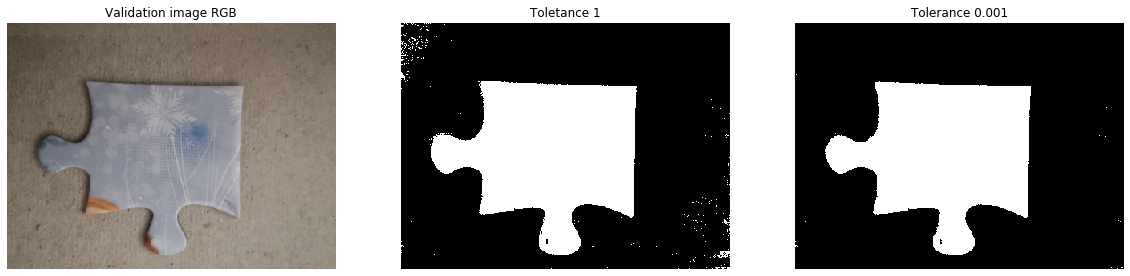

In [60]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Validation image RGB")
plt.imshow(X_raw[21])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Toletance 1")
plt.imshow(images_tolerance[0])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Tolerance 0.001")
plt.imshow(images_tolerance[len(images_tolerance)-2])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.show()

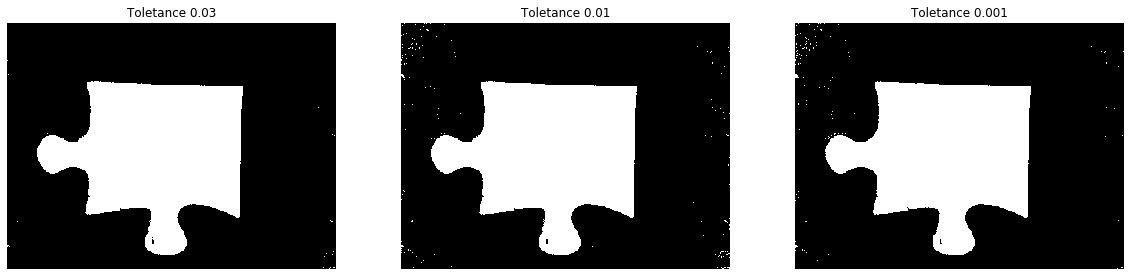

In [61]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Toletance 0.03")
plt.imshow(images_tolerance[1])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Toletance 0.01")
plt.imshow(images_tolerance[2])
# Turn off the axis numbering
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Toletance 0.001")
plt.imshow(images_tolerance[4])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.show()

#### 5.1.1 RGB with random weights 

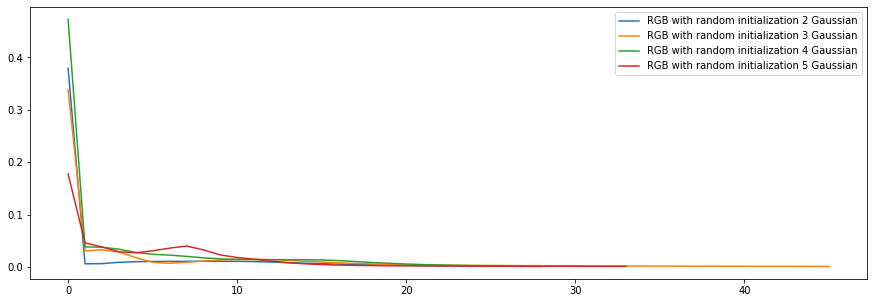

In [15]:
# List1  
tables = ['RGB 2 Gaussian', 'RGB 3 Gaussian', 'RGB 4 Gaussian', 'RGB 5 Gaussian']  

# List2
data2 = [0.3789598549406549,0.005912747437482601,0.00627124393682809,0.008830941482259571,0.009962485766560827
         ,0.010439943858705556 ,0.010626283549042269,0.010736059462937096,0.010837188737017025,0.01086756496398512
         ,0.010678440071510212,0.01013798001725074,0.009265088617225909,0.00821568927796391,0.00715791745934224
         ,0.006187936547252256,0.005340751024043299,0.004624147086191664,0.004031377137060641,0.0035421586324774516
         ,0.0031268406193187305,0.0027561465366564685,0.0024087859194614003,0.0020728063157361477,0.0017459856098482273
         ,0.001436957250396181,0.001160112911873539,0.0009256222871916343]

data3 = [0.3389909976687044,0.030650973313542006,0.032711684421469454,0.028521449377829532,0.017727295995987366
         ,0.008798968119528157,0.006963373960539044,0.008955244527112874,0.011260001764205668,0.01316691084499404
         ,0.01431559452470824,0.014494571152618293,0.01377104166508792,0.012439516686957532,0.010849426421301685
         ,0.009270198063609476,0.007855191469227469,0.006665269790017059,0.005704306985800895,0.004947087691251389
         ,0.004357259395319978,0.003897672903485296,0.003535617015463614,0.003244777773994882,0.0030052564170853354
         ,0.002802650456169163,0.0026268487341058943,0.0024708907172266183,0.002330041035652808,0.0022011020753179137
         ,0.002081923579595236,0.0019710566131823266,0.0018675108859214809,0.0017705873083237902,0.0016797655810983935
         ,0.0015946313042896965,0.0015148306181295883,0.0014400434121893309,0.0013699686462841031,0.0013043172790255769
         ,0.0012428097341157917,0.0011851758754200293,0.001131156137391279,0.001080503019449246,0.0010329824538381398
         ,0.0009883748022331438]

data4 = [0.4726716876273368,0.038345320431562906,0.03755728042844828,0.033935873733342364,0.02764851540379715
         ,0.02406500905306339,0.022570820767554782,0.020128054434702378,0.0172829741884383,0.015390538056937271
         ,0.014419701742668852,0.01399582893397443,0.013869896082453731,0.013852222729527186,0.013717618347257984
         ,0.013277725857428093,0.012061261852683592,0.010269857362187268,0.008456363759133967,0.006856788956819333
         ,0.005520289833063332,0.0044282169307221925,0.0035440058715034885,0.002831068804501968,0.0022577636270079645
         ,0.001797862409359106,0.0014298427244396235,0.0011360732094229371,0.0009021326273430514]

data5 = [0.1774501219245029,0.0457890817690006,0.03822270916344246,0.028905871414910522,0.026981528349663213
         ,0.030772479783247653,0.035845644676420076,0.03987909655057639,0.03257402881953323,0.022888207565545826
         ,0.017974940281576708,0.014689956363517746,0.011071659766587642,0.008062292808058823,0.005940094816263
         ,0.004494259328810685,0.0035177236564509144,0.0028735498690332186,0.0024590329353208853,0.0021930216857179666
         ,0.0020162971730416203,0.0018900563874088173,0.0017909218620959606,0.0017055740666013636,0.0016267545132325248
         ,0.0015507308382407773,0.0014757856577870684,0.0014013286313611939,0.0013273734335972145,0.0012542292469942386
         ,0.001182320608663569,0.0011120852373489635,0.0010439195299267387,0.0009781529976211792]


RGB2 = pd.DataFrame({tables[0]: data2})
RGB3 = pd.DataFrame({tables[1]: data3})
RGB4 = pd.DataFrame({tables[2]: data4})
RGB5 = pd.DataFrame({tables[3]: data5})


plt.figure(figsize=(15, 5))
plt.plot(RGB2,label="RGB with random initialization 2 Gaussian")
plt.plot(RGB3,label="RGB with random initialization 3 Gaussian")
plt.plot(RGB4,label="RGB with random initialization 4 Gaussian")
plt.plot(RGB5,label="RGB with random initialization 5 Gaussian")
plt.legend()
plt.show()

#### 5.1.2 RGB with kmeans weights 

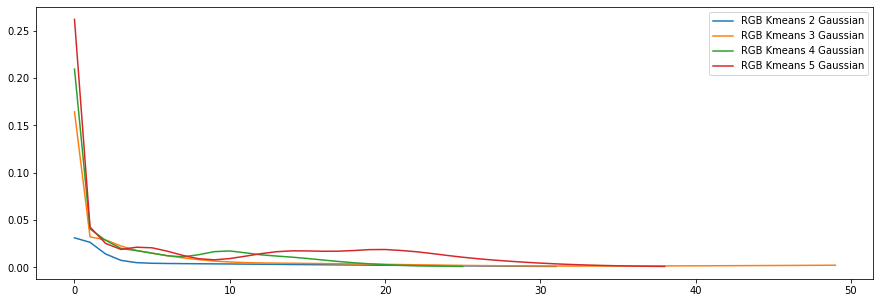

In [16]:
# List1  
tables = ['RGB 2 Gaussian', 'RGB 3 Gaussian', 'RGB 4 Gaussian', 'RGB 5 Gaussian']  

#list 2 
data2 = [0.031162469,0.02642044,0.014105668,0.007316382,0.0049300794,0.004275723,0.004040173,0.0038939836,0.0037687363
         ,0.003646149,0.003520257,0.003389694,0.003254846,0.0031170838,0.0029780297,0.0028392419,0.0027018774,0.0025667995,0.0024338472
         ,0.002302964,0.002173725,0.002045948,0.0019196745,0.0017950851,0.0016727871,0.001553313,0.0014372584,0.0013255242
         ,0.0012185212,0.0011167492,0.0010204813,0.00093005924]

data3 = [0.1642226,0.032175288,0.028973438,0.022455003,0.01782416,0.014909969,0.012232406,0.009978425,0.00810873,0.0066513317,
         0.0056354576,0.005002256,0.004641046,0.004433941,0.0042875526,0.0041420935,0.003972685,0.0037822877,0.0035792654,0.0033680669
         ,0.0031492189,0.0029225885,0.0026905006,0.0024597268,0.00223928,0.0020376586,0.0018610753,0.0017129963,0.0015938595,0.0015024877
         ,0.0014363591,0.001392433,0.0013676098,0.0013588918,0.0013638848,0.0013803731,0.0014066859,0.0014414146,0.0014833916
         ,0.0015316607,0.0015855003,0.0016441449,0.0017070763,0.001773692,0.0018435954,0.0019162259,0.0019912263,0.0020682018
         ,0.0021468145,0.0022266987]

data4 = [0.20942192,0.04047765,0.028566392,0.019869732,0.017617084,0.014938177,0.01217109,0.011096732,0.013317527,0.016561493
         ,0.01728644,0.015327171,0.013212397,0.0119175445,0.010746815,0.009319098,0.0077207675,0.0061656744,0.004800063
         ,0.0036831233,0.0028159104,0.00216907,0.0017016827,0.0013718273,0.0011414149,0.0009790746]

data5 = [0.2619766,0.042591445,0.025249146,0.018886449,0.021239435,0.020605875,0.016957188,0.01248437,0.009071778
         ,0.007923847,0.009261084,0.011743451,0.014399347,0.016486973,0.017407047,0.017305106,0.016964052,0.017043391
         ,0.017746113,0.018703453,0.018821962,0.017809905,0.01647608,0.014609324,0.012554081,0.010665587,0.009038625
         ,0.007648944,0.0064422744,0.0053806677,0.0044502816,0.0036496404,0.0029758532,0.002421091,0.0019720774,0.0016128886
         ,0.0013276513,0.0011016229,0.0009220591]

RGB2 = pd.DataFrame({tables[0]: data2})
RGB3 = pd.DataFrame({tables[1]: data3})
RGB4 = pd.DataFrame({tables[2]: data4})
RGB5 = pd.DataFrame({tables[3]: data5})


plt.figure(figsize=(15, 5))
plt.plot(RGB2,label="RGB Kmeans 2 Gaussian")
plt.plot(RGB3,label="RGB Kmeans 3 Gaussian")
plt.plot(RGB4,label="RGB Kmeans 4 Gaussian")
plt.plot(RGB5,label="RGB Kmeans 5 Gaussian")
plt.legend()
plt.show()

#### DOG+RGB 

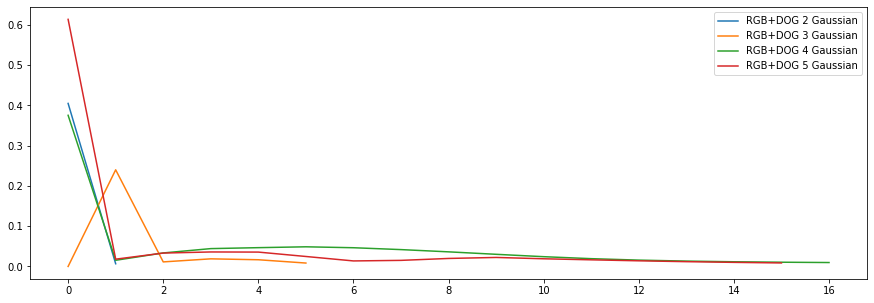

In [17]:
# List1  
tables = ['RGB 2 Gaussian', 'RGB 3 Gaussian', 'RGB 4 Gaussian', 'RGB 5 Gaussian']  

#list 2 
data2 = [0.4049963392004947,0.0067212098632404614]

data3 = [0, 0.24006244453150247,0.011293927698868715,0.018895417768324742,0.016642600641006356,0.00843935787880514]

data4 = [0.37548137912177615,0.015318294846676527,0.033552976079249064,0.04430419815342794,0.04667253690419788
         ,0.04879249915683758,0.046483321343483486,0.04185005814730893,0.03626337710529967,0.030152745110464785
         ,0.024243855980924874,0.019330766440161573,0.0157307798467723,0.013278572216838987,0.011629613535991061
         ,0.010501838126984173,0.009722534633972772]

data5 = [0.6138449835657597,0.018078395935830903,0.033232415122010986,0.03598084663210711,0.035658332299622245
         ,0.024740126003598418,0.013698800900111923,0.015087598175811148,0.01987696494774467,0.022356403223292534
         ,0.019044142628680674,0.016444179906494723,0.013996490915855787,0.011879868865615392,0.010126811204961504
         ,0.008704508368070638]

RGB2 = pd.DataFrame({tables[0]: data2})
RGB3 = pd.DataFrame({tables[1]: data3})
RGB4 = pd.DataFrame({tables[2]: data4})
RGB5 = pd.DataFrame({tables[3]: data5})


plt.figure(figsize=(15, 5))
plt.plot(RGB2,label="RGB+DOG 2 Gaussian")
plt.plot(RGB3,label="RGB+DOG 3 Gaussian")
plt.plot(RGB4,label="RGB+DOG 4 Gaussian")
plt.plot(RGB5,label="RGB+DOG 5 Gaussian")
plt.legend()
plt.show()



#### HSV+DOG

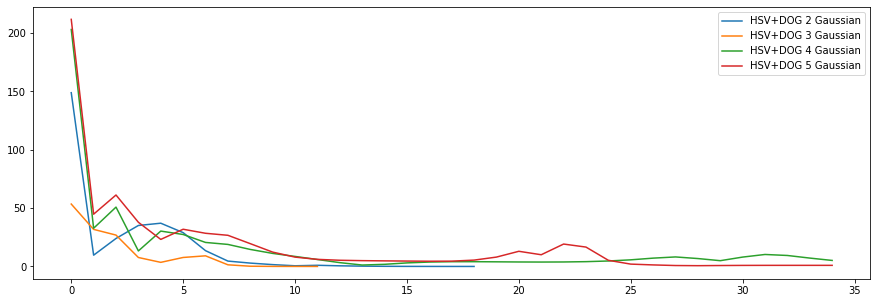

In [18]:

# List1  
tables = ['RGB 2 Gaussian', 'RGB 3 Gaussian', 'RGB 4 Gaussian', 'RGB 5 Gaussian']  

#list 2 
data2 = [148.93651238965847,9.667980652620964,23.983397179646406,35.11884279989644,37.06863687380489
         ,28.988921227410486,13.52896465739016,4.600895281460609,2.874153537123171,1.5694699662111111
         ,0.5754747826365435,0.9925596540301905,0.5427478118677361,0.26661654778243976,0.12519486254325896
         ,0.05691695381722053,0.02521107145900419,0.011017031501889882,0.004783994546464086]

data3 = [53.48455598718722,31.773262406568424,26.89095620386582,7.673162196246438,3.512581762994077
         ,7.701239146767651,9.10719833923661,1.4087353525700166,0.19595552681749973,0.050656768726093405
         ,0.01913273750395791,0.00788325073167842]

data4 = [203.09249755617824,32.75043824769696,50.86117471845106,13.302664569913196,30.312371102780318
         ,27.39466542334963,20.583171395358086,18.8803553895945,14.581744873758154,11.183096756647318
         ,8.588899130031239,5.948437301444971,3.2690918006596292,1.2151681122818336,1.830035363562922
         ,3.0457672016119104,3.7731971592535047,4.069050517603883,4.083454826754098,3.965296042456639
         ,3.8342362575014586,3.7716368242370977,3.840398569979548,4.110036245558665,4.677787051286683
         ,5.673903800374914,7.125022553341663,8.150905548129089,6.773733844786015,4.941312229657921
         ,8.026887704355747,10.26404215030961,9.408296255619765,7.172347650152619,5.1552706853488885]

data5 = [211.78357474030236,44.799856326456016,61.240082145718766,37.84990366942561,23.179091433895557
         ,31.892367928246973,28.432868528983935,26.697771797262185,19.540391848532487,12.300532696019516
         ,8.004478525131606,6.07119178982673,5.303458732219703,4.976055077213188,4.782843791377648
         ,4.6140368987647005,4.471811515797338,4.545997569129087,5.4384600353942005,8.023235193757781
         ,12.992769045916237,10.036665537228183,19.19279643480369,16.604706838588775,5.269544888718814
         ,2.0024766292198817,1.3130279128242395,0.7921949753091163,0.6586134480015029,0.7962380282307663
         ,0.8977349742596872,0.9367315707673856,0.9450803688735887,0.945114210733123,0.9452128561690296]

RGB2 = pd.DataFrame({tables[0]: data2})
RGB3 = pd.DataFrame({tables[1]: data3})
RGB4 = pd.DataFrame({tables[2]: data4})
RGB5 = pd.DataFrame({tables[3]: data5})


plt.figure(figsize=(15, 5))
plt.plot(RGB2,label="HSV+DOG 2 Gaussian")
plt.plot(RGB3,label="HSV+DOG 3 Gaussian")
plt.plot(RGB4,label="HSV+DOG 4 Gaussian")
plt.plot(RGB5,label="HSV+DOG 5 Gaussian")
plt.legend()
plt.show()

### Inference for RGB Test Image

This section uses up to 9 GMMs to infer on the image in contrast to the 3 used on the previous section for testing the tolerance threshold.

In [62]:
import random
images_RGB_test = []
probs = []
print('the index of the image used was',rand_image)

for i in range(2, 10):
    pickle_off0 = open("pickles/gmm_puzzle-RGB-"+str(i)+".pickle","rb")
    gmm_puzzle = pickle.load(pickle_off0)
    
    pickle_off1 = open("pickles/gmm_background-RGB-"+str(i)+".pickle","rb")
    gmm_background = pickle.load(pickle_off1)
    
    index = 21
    image, mask = (X_raw[index], Y_raw[index])

    ##### The inference as specified in the question using the background and the puzzle pixels gmm
    likelihood1 = gmm_background.Proba(image) #probability of being background
    likelihood2 = gmm_puzzle.Proba(image) #probability of being foreground
    
    prior1 = prior_RGB
    prior2 = 1 - prior_RGB 
    
    foreground_prior = prior2 * likelihood2
    Background_prior = foreground_prior + (prior1 * likelihood1)
    
    prob = foreground_prior/Background_prior   
    #######
    
    prob[prob>0.5] = 1
    prob[prob<0.5] = 0
    
    images_RGB_test.append(prob)
    
    prob = prob.ravel().astype(int)
    mask = mask.ravel()
    score = accuracy_score(mask, prob)*100
    print("The accuracy for GMM validation with RGB",i,"is :",score)
    probs.append(prob)

the index of the image used was 1
The accuracy for GMM validation with RGB 2 is : 99.38031302137126
The accuracy for GMM validation with RGB 3 is : 99.64804957495829
The accuracy for GMM validation with RGB 4 is : 99.60355922777468
The accuracy for GMM validation with RGB 5 is : 99.68380074680225
The accuracy for GMM validation with RGB 6 is : 99.59958687534758
The accuracy for GMM validation with RGB 7 is : 99.63613251767697
The accuracy for GMM validation with RGB 8 is : 99.57893064272663
The accuracy for GMM validation with RGB 9 is : 99.61627075554144


This is the confusion matrix for mask 21 and GMM mask 2: 
 [[90915   600]
 [  180 34175]]
This is the confusion matrix for mask 21 and GMM mask 3: 
 [[91267   248]
 [  195 34160]]
This is the confusion matrix for mask 21 and GMM mask 4: 
 [[91262   253]
 [  246 34109]]
This is the confusion matrix for mask 21 and GMM mask 5: 
 [[91322   193]
 [  205 34150]]
This is the confusion matrix for mask 21 and GMM mask 6: 
 [[91226   289]
 [  215 34140]]
This is the confusion matrix for mask 21 and GMM mask 7: 
 [[91298   217]
 [  241 34114]]
This is the confusion matrix for mask 21 and GMM mask 8: 
 [[91225   290]
 [  240 34115]]
This is the confusion matrix for mask 21 and GMM mask 9: 
 [[91279   236]
 [  247 34108]]


This is the cohens kappa score for mask 21 and GMM mask 2: 0.9844457294565385
This is the cohens kappa score for mask 21 and GMM mask 3:  0.9911365145031618
This is the cohens kappa score for mask 21 and GMM mask 4:  0.9900118993305664
This is the cohens kappa score for mask 21

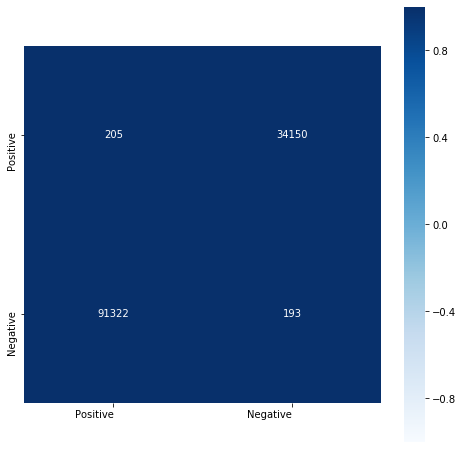

In [67]:
Ind_here = Metrics_CM_CK_IOU_nine(Y_raw,index,images_RGB_test)

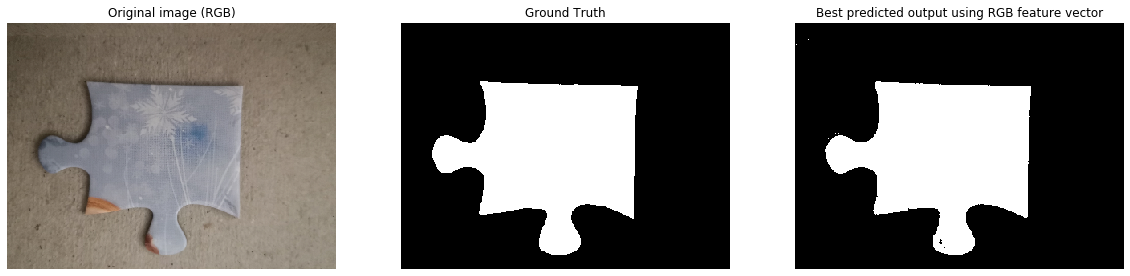

In [69]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original image (RGB)")
plt.imshow(X_raw[21])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(Y_raw[21])
# Turn off the axis numbering
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Best predicted output using RGB feature vector")
plt.imshow(images_RGB_test[Ind_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

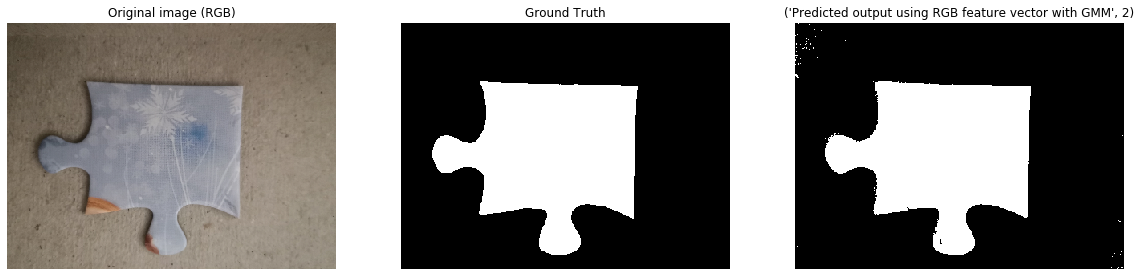

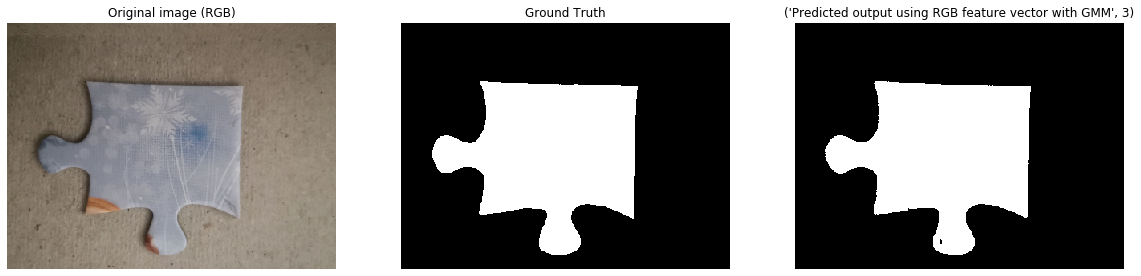

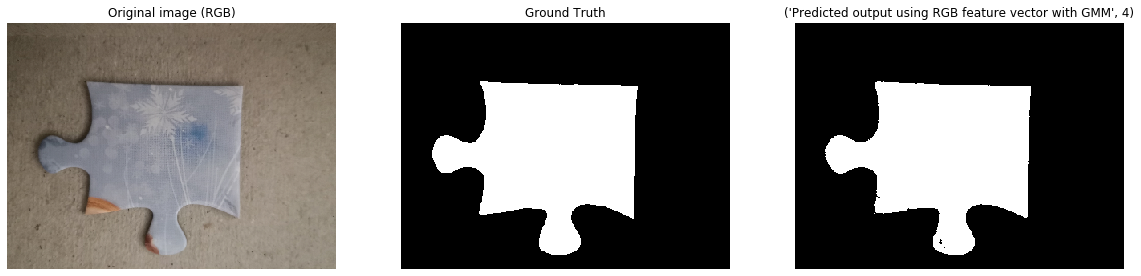

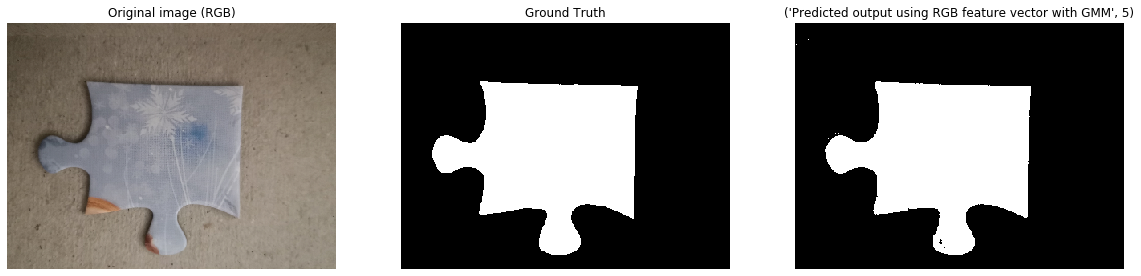

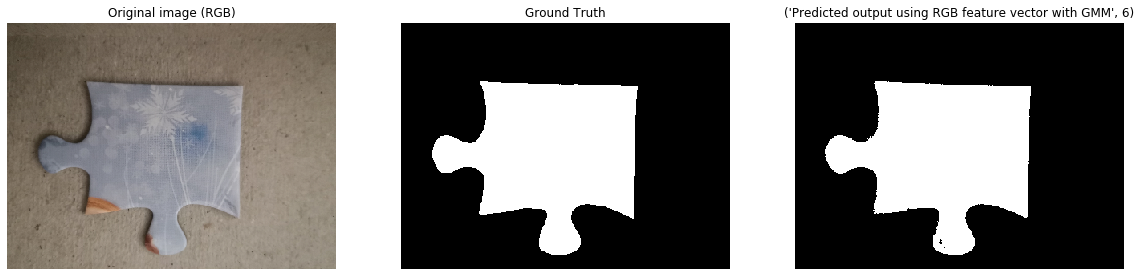

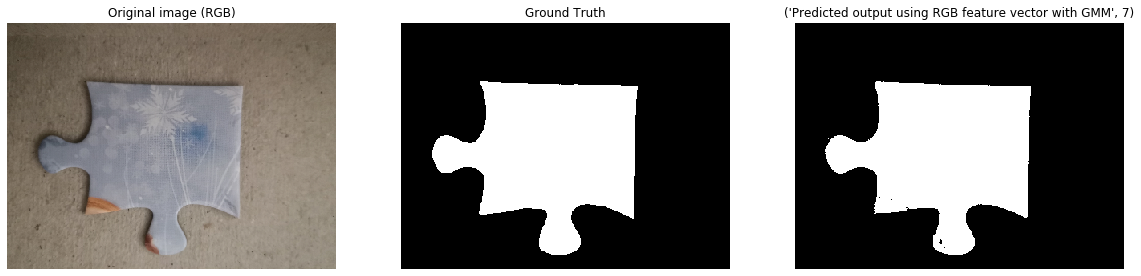

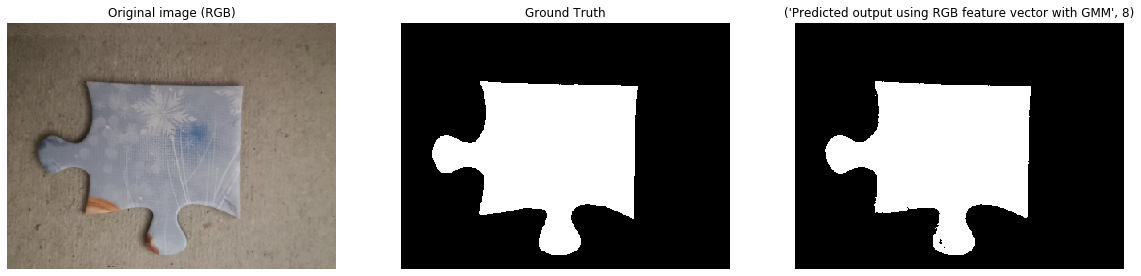

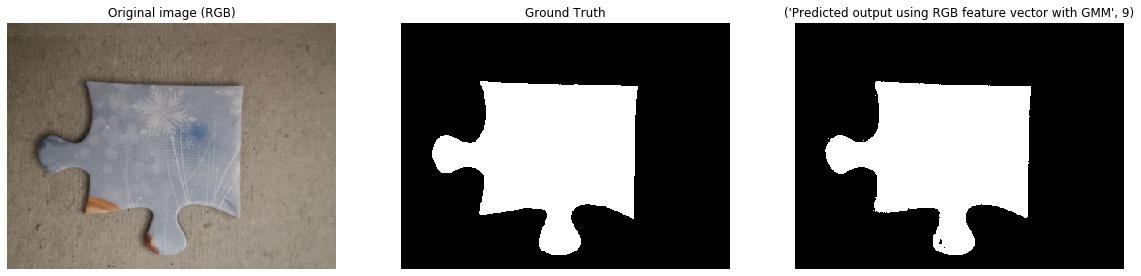

In [72]:
for i in range(len(images_RGB)):
    # Spawn a new figure
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.title("Original image (RGB)")
    plt.imshow(X_raw[21])
    # Turn off axis numbering
    plt.axis('off')

    # Show the second image
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(Y_raw[21])
    # Turn off the axis numbering
    plt.axis('off')


    plt.subplot(1,3,3)
    titles="Predicted output using RGB feature vector with GMM",2+i
    plt.title(titles)
    plt.imshow(images_RGB_test[i])
    # Turn off the axis numbering
    plt.axis('off')

    # Show the figure
    plt.grid(b=None)
    plt.show()

### Inference for RGB Validation Image

In [73]:
import random
images_RGB = []
probs = []
rand_image = random.randint(0, 6)#4
print('the index of the image used was',rand_image)

for i in range(2, 10):
    pickle_off0 = open("pickles/gmm_puzzle-RGB-"+str(i)+".pickle","rb")
    gmm_puzzle = pickle.load(pickle_off0)
    
    pickle_off1 = open("pickles/gmm_background-RGB-"+str(i)+".pickle","rb")
    gmm_background = pickle.load(pickle_off1)
    
    index = rand_image
    image, mask = (valid_X[index], valid_y[index])

    ##### The inference as specified in the question using the background and the puzzle pixels gmm
    likelihood1 = gmm_background.Proba(image) #probability of being background
    likelihood2 = gmm_puzzle.Proba(image) #probability of being foreground
    
    prior1 = prior_RGB
    prior2 = 1 - prior_RGB 
    
    foreground_prior = prior2 * likelihood2
    Background_prior = foreground_prior + (prior1 * likelihood1)
    
    prob = foreground_prior/Background_prior   
    #######
    
    prob[prob>0.5] = 1
    prob[prob<0.5] = 0
    
    images_RGB.append(prob)
    
    prob = prob.ravel().astype(int)
    mask = mask.ravel()
    score = accuracy_score(mask, prob)*100
    print("The accuracy for GMM validation with RGB",i,"is :",score)
    probs.append(prob)

the index of the image used was 3
The accuracy for GMM validation with RGB 2 is : 93.32962580440136
The accuracy for GMM validation with RGB 3 is : 92.52721061412569
The accuracy for GMM validation with RGB 4 is : 93.82537538730436
The accuracy for GMM validation with RGB 5 is : 93.86509891157544
The accuracy for GMM validation with RGB 6 is : 93.38523873838088
The accuracy for GMM validation with RGB 7 is : 93.30896957178041
The accuracy for GMM validation with RGB 8 is : 93.87383808691507
The accuracy for GMM validation with RGB 9 is : 93.38126638595377


This is the confusion matrix for mask 3 and GMM mask 2: 
 [[90000  1652]
 [ 6744 27474]]
This is the confusion matrix for mask 3 and GMM mask 3: 
 [[90269  1383]
 [ 8023 26195]]
This is the confusion matrix for mask 3 and GMM mask 4: 
 [[90141  1511]
 [ 6261 27957]]
This is the confusion matrix for mask 3 and GMM mask 5: 
 [[90579  1073]
 [ 6649 27569]]
This is the confusion matrix for mask 3 and GMM mask 6: 
 [[90193  1459]
 [ 6867 27351]]
This is the confusion matrix for mask 3 and GMM mask 7: 
 [[90672   980]
 [ 7442 26776]]
This is the confusion matrix for mask 3 and GMM mask 8: 
 [[90130  1522]
 [ 6189 28029]]
This is the confusion matrix for mask 3 and GMM mask 9: 
 [[90307  1345]
 [ 6986 27232]]


This is the cohens kappa score for mask 3 and GMM mask 2: 0.8232721768893512
This is the cohens kappa score for mask 3 and GMM mask 3:  0.7990245490612237
This is the cohens kappa score for mask 3 and GMM mask 4:  0.8369423913590692
This is the cohens kappa score for mask 3 and GMM mas

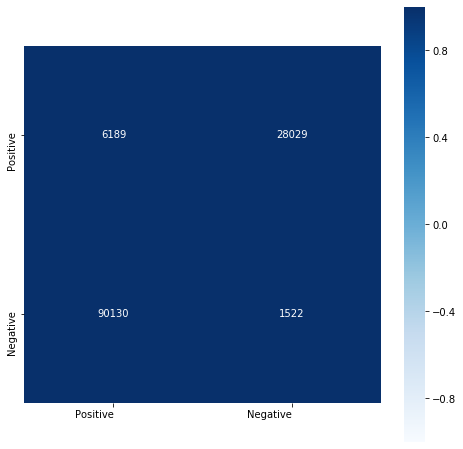

In [74]:
Ind_here = Metrics_CM_CK_IOU_nine(valid_y,index,images_RGB)

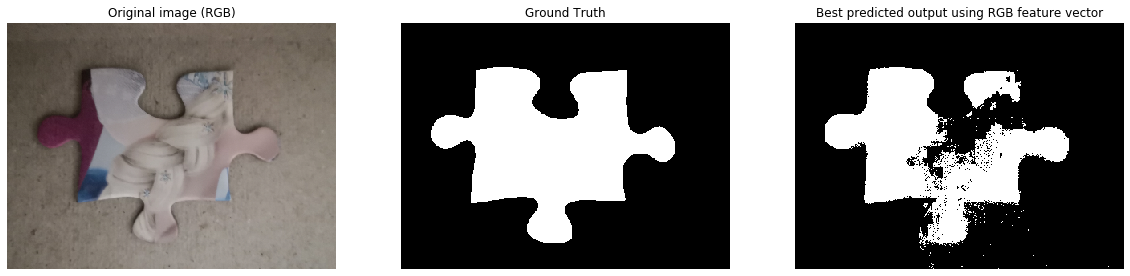

In [75]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original image (RGB)")
plt.imshow(valid_X[rand_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(valid_y[rand_image])
# Turn off the axis numbering
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Best predicted output using RGB feature vector")
plt.imshow(images_RGB[Ind_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

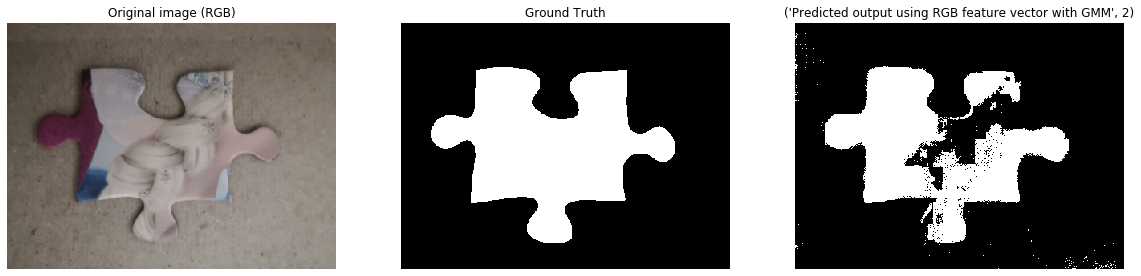

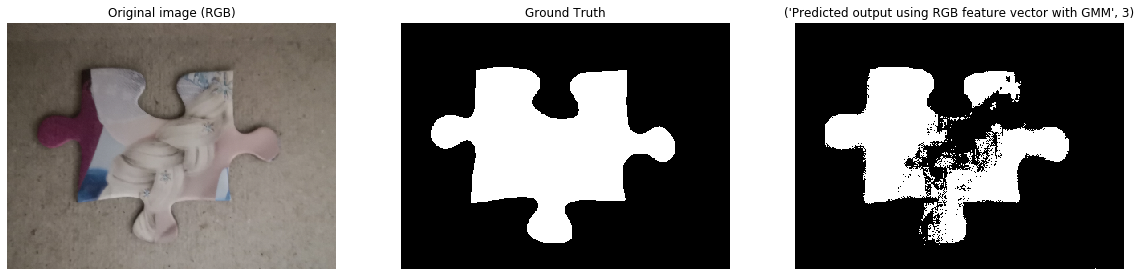

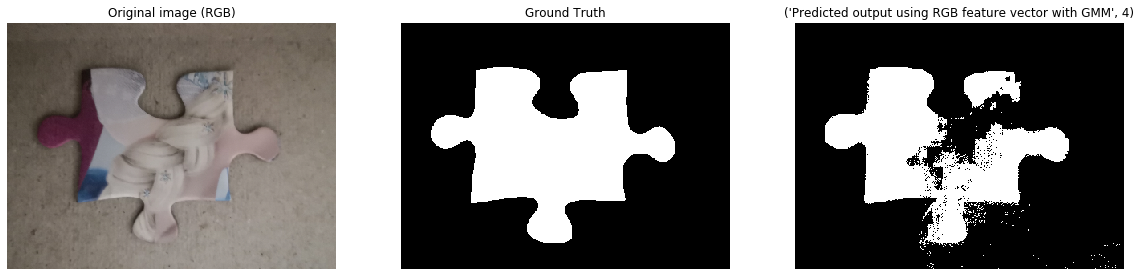

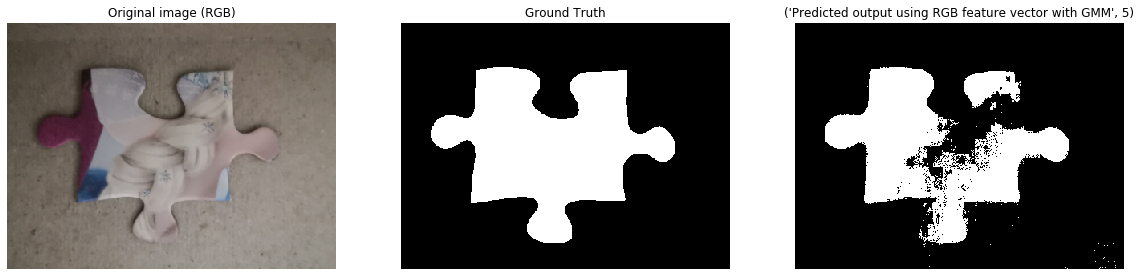

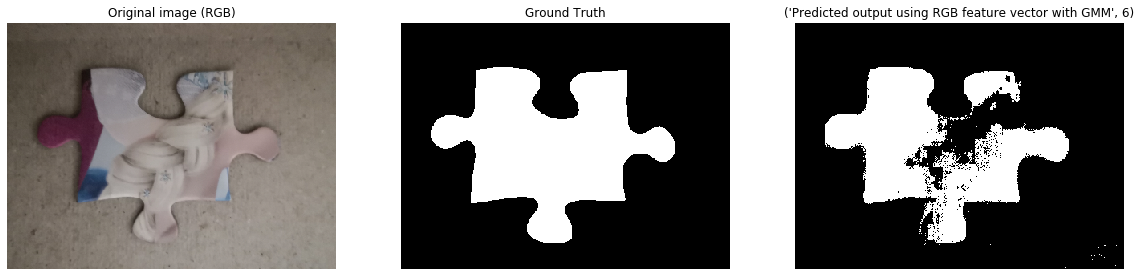

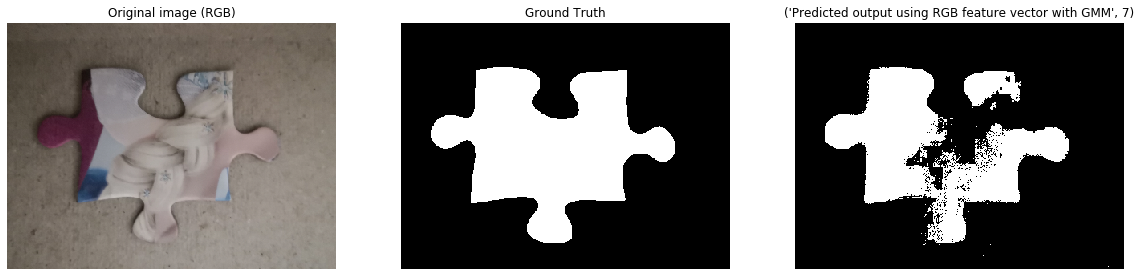

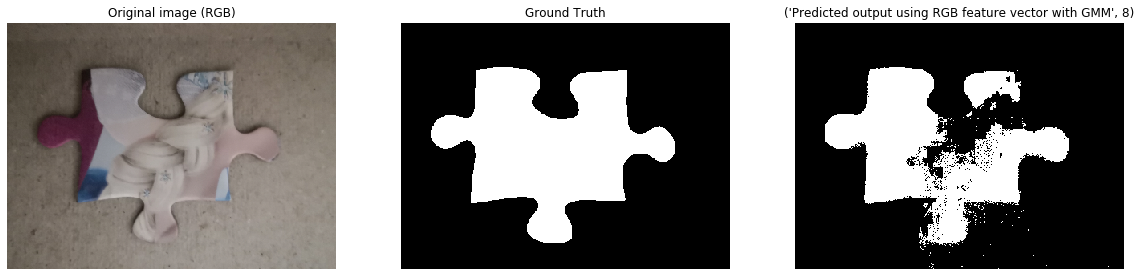

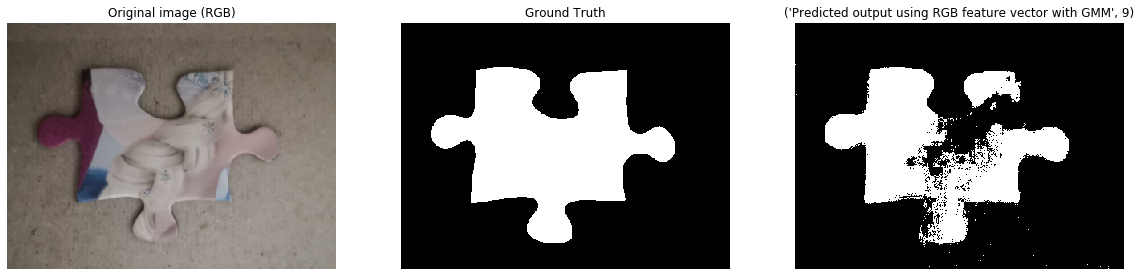

In [76]:
for i in range(len(images_RGB)):
    # Spawn a new figure
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.title("Original image (RGB)")
    plt.imshow(valid_X[rand_image])
    # Turn off axis numbering
    plt.axis('off')

    # Show the second image
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(valid_y[rand_image])
    # Turn off the axis numbering
    plt.axis('off')


    plt.subplot(1,3,3)
    titles="Predicted output using RGB feature vector with GMM",2+i
    plt.title(titles)
    plt.imshow(images_RGB[i])
    # Turn off the axis numbering
    plt.axis('off')

    # Show the figure
    plt.grid(b=None)
    plt.show()

### Inference for RGB+DOG

In [77]:
images_RGBDOG = []
probs = []
rand_image = random.randint(0, 6)#0
print('the index of the image used was',rand_image)

for i in range(2, 6):
    pickle_off0 = open("pickles/gmm_puzzle-RGBDOG-"+str(i)+".pickle","rb")
    gmm_puzzle = pickle.load(pickle_off0)
    
    pickle_off1 = open("pickles/gmm_background-RGBDOG-"+str(i)+".pickle","rb")
    gmm_background = pickle.load(pickle_off1)
    
    index = rand_image
    image, mask = (valid_X[index], valid_y[index])

    ##### The inference as specified in the question using the background and the puzzle pixels gmm
    likelihood1 = gmm_background.Proba(image) #probability of being background
    likelihood2 = gmm_puzzle.Proba(image) #probability of being foreground
    
    prior1 = prior_RGBDOG
    prior2 = 1 - prior_RGBDOG 
    
    foreground_prior = prior2 * likelihood2
    Background_prior = foreground_prior + (prior1 * likelihood1)
    
    prob = foreground_prior/Background_prior   
    #######
    
    prob[prob>0.5] = 1
    prob[prob<0.5] = 0
    
    images_RGBDOG.append(prob)
    
    prob = prob.ravel().astype(int)
    mask = mask.ravel()
    score = accuracy_score(mask, prob)*100
    print("The accuracy for GMM",i,"is :",score)
    probs.append(prob)

the index of the image used was 4
The accuracy for GMM 2 is : 95.65742432668627
The accuracy for GMM 3 is : 96.19845872725828
The accuracy for GMM 4 is : 97.66981806625884
The accuracy for GMM 5 is : 98.2609041074124


This is the confusion matrix for mask 4 and GMM 2: 
 [[90753   298]
 [ 5168 29651]]
This is the confusion matrix for mask 4 and GMM 3: 
 [[88652  2399]
 [ 2386 32433]]
This is the confusion matrix for mask 4 and GMM 4: 
 [[89820  1231]
 [ 1702 33117]]
This is the confusion matrix for mask 4 and GMM 5: 
 [[90700   351]
 [ 1838 32981]]


This is the cohens kappa score for mask 4 and GMM 2: 0.8865942522452618
This is the cohens kappa score for mask 4 and GMM 3:  0.9050219831483285
This is the cohens kappa score for mask 4 and GMM 4:  0.9415316052634686
This is the cohens kappa score for mask 4 and GMM 5: 0.955964558432492


The intersection over union of the predicted GMM 2 and mask 4 :  0.45780323616600793
The intersection over union of the predicted GMM 3 and mask 4 :  0.46565017013395354
The intersection over union of the predicted GMM 4 and mask 4 :  0.47879769254124077
The intersection over union of the predicted GMM 5 and mask 4 :  0.48394007424689295


-----------------------------

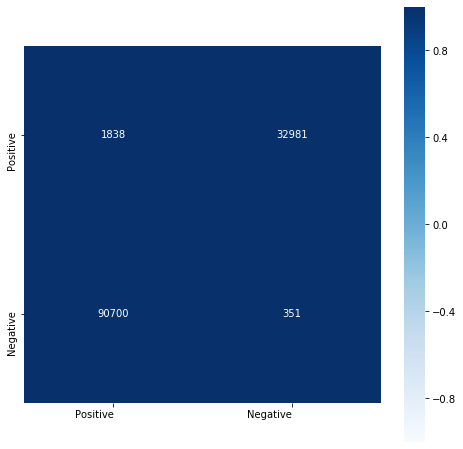

In [78]:
Ind_here =Metrics_CM_CK_IOU(valid_y,index,images_RGBDOG)

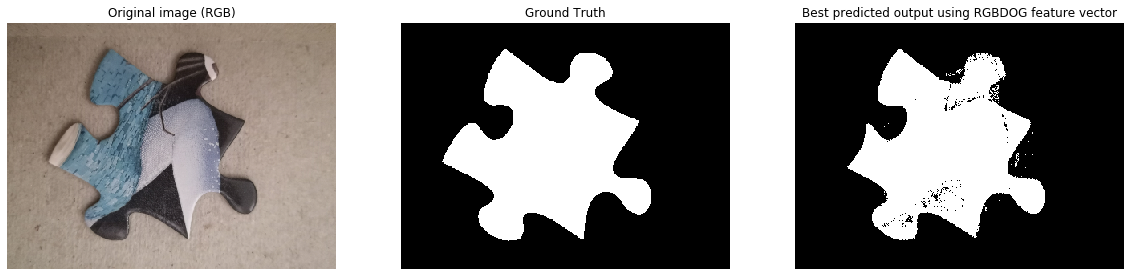

In [79]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original image (RGB)")
plt.imshow(valid_X[rand_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(valid_y[rand_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output using RGBDOG feature vector")
plt.imshow(images_RGBDOG[Ind_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

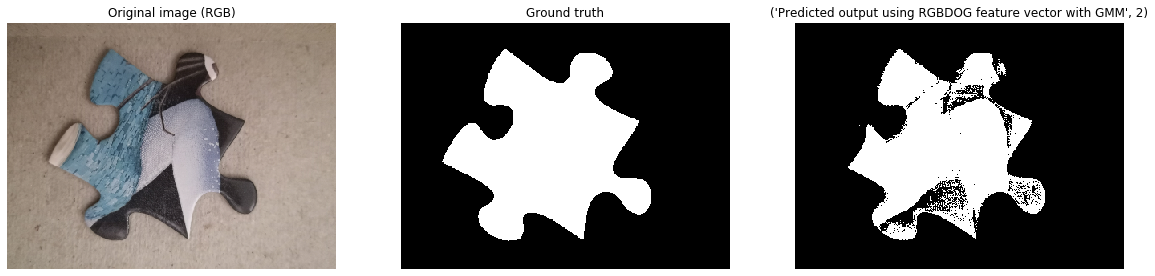

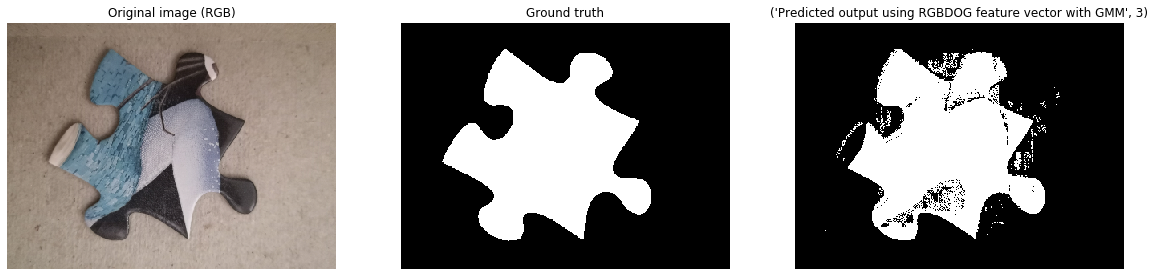

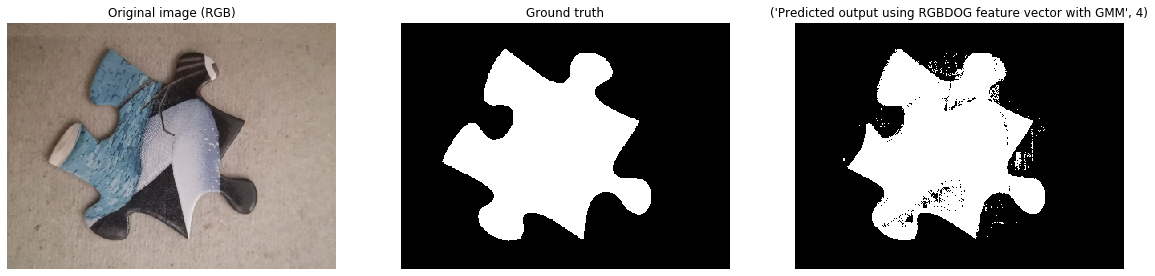

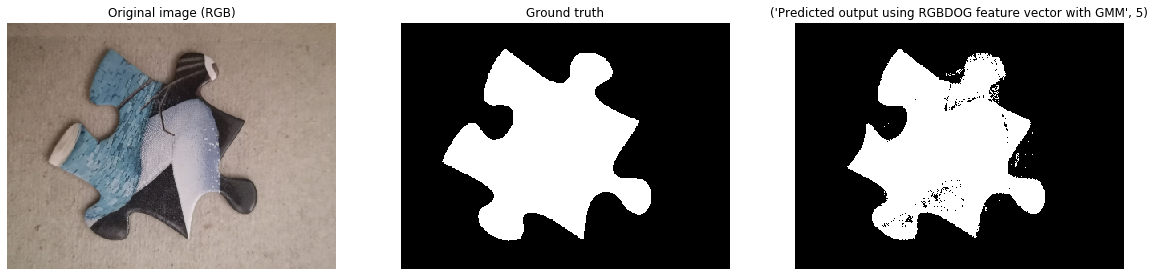

In [80]:
for i in range(len(images_RGBDOG)):
    # Spawn a new figure
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.title("Original image (RGB)")
    plt.imshow(valid_X[rand_image])
    # Turn off axis numbering
    plt.axis('off')

    # Show the second image
    plt.subplot(1,3,2)
    plt.title("Ground truth")
    plt.imshow(valid_y[rand_image])
    # Turn off the axis numbering
    plt.axis('off')


    plt.subplot(1,3,3)
    titles="Predicted output using RGBDOG feature vector with GMM",2+i
    plt.title(titles)
    plt.imshow(images_RGBDOG[i])
    # Turn off the axis numbering
    plt.axis('off')

    # Show the figure
    plt.grid(b=None)
    plt.show()

### Inference for HSV+DOG training Images

In [100]:
images_HSVDOG_train = []
covariance_background = np.cov(background_pixel_HSVDOG.T)
mean_background = np.mean(background_pixel_HSVDOG, 0)  

rand_image = random.randint(0, 6)#4
print('the index of the image used was',rand_image)

probs = []

for i in range(2, 6):
    pickle_off0 = open("pickles/gmm_puzzle-HSVDOG-"+str(i)+".pickle","rb")
    gmm_puzzle = pickle.load(pickle_off0)
    
    testing_image = rand_image #selecting random number
    image, mask = (train_X_HSV[testing_image], train_y[testing_image])

    likelihood = gmm_puzzle.Proba(image)
    part1 = prior_RGB*likelihood
    part2 = ((1-prior_RGB)*multivariate_normal(mean=mean_background, cov=covariance_background).pdf(image))
    part3 = part1 + part2 
    prob = part1/part3

    prob[prob>0.5] = 1
    prob[prob<0.5] = 0
    
    images_HSVDOG_train.append(prob)
    
    prob = prob.ravel().astype(int)
    mask = mask.ravel()
    curr_acc = accuracy_score(mask, prob)*100
    print("The accuracy ",i,"is :",curr_acc)
    probs.append(prob)

the index of the image used was 6
The accuracy  2 is : 99.08238658933821
The accuracy  3 is : 99.30166044331453
The accuracy  4 is : 99.30722173671248
The accuracy  5 is : 99.3969969015651


This is the confusion matrix for mask 6 and GMM 2: 
 [[92707   763]
 [  392 32008]]
This is the confusion matrix for mask 6 and GMM 3: 
 [[92939   531]
 [  348 32052]]
This is the confusion matrix for mask 6 and GMM 4: 
 [[92989   481]
 [  391 32009]]
This is the confusion matrix for mask 6 and GMM 5: 
 [[93059   411]
 [  348 32052]]


This is the cohens kappa score for mask 6 and GMM 2: 0.9760869249366861
This is the cohens kappa score for mask 6 and GMM 3:  0.9817667847723428
This is the cohens kappa score for mask 6 and GMM 4:  0.981895040972792
This is the cohens kappa score for mask 6 and GMM 5: 0.9842369237467767


The intersection over union of the predicted GMM 2 and mask 6 :  0.4911386966595572
The intersection over union of the predicted GMM 3 and mask 6 :  0.4932366926734684
The intersection over union of the predicted GMM 4 and mask 6 :  0.4932809369702574
The intersection over union of the predicted GMM 5 and mask 6 :  0.4941492067896952


---------------------------------

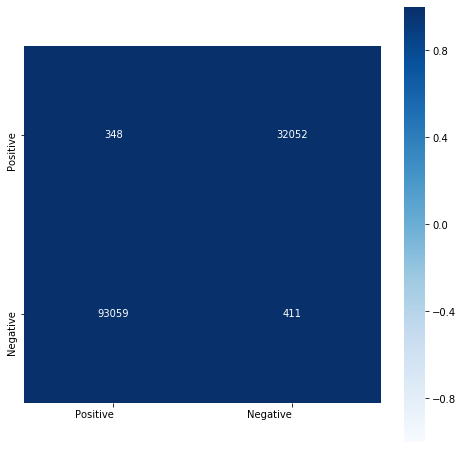

In [101]:
Ind_here = Metrics_CM_CK_IOU(train_y,testing_image,images_HSVDOG_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


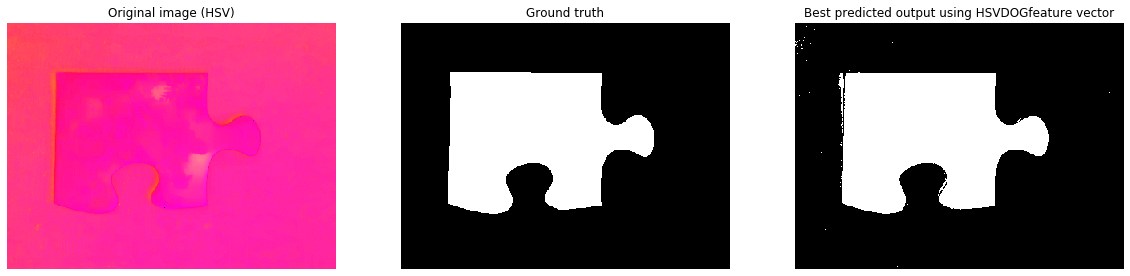

In [103]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original image (HSV)")
plt.imshow(train_X_HSV[rand_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(train_y[rand_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output using HSVDOGfeature vector")
plt.imshow(images_HSVDOG_train[Ind_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

### Inference for HSV+DOG validation Images

In [104]:
images_HSVDOG = []
covariance_background = np.cov(background_pixel_HSVDOG.T)
mean_background = np.mean(background_pixel_HSVDOG, 0)  

rand_image = random.randint(0, 6)#4
print('the index of the image used was',rand_image)

probs = []

for i in range(2, 6):
    pickle_off0 = open("pickles/gmm_puzzle-HSVDOG-"+str(i)+".pickle","rb")
    gmm_puzzle = pickle.load(pickle_off0)
    
    testing_image = rand_image #selecting random number
    image, mask = (valid_X_HSV[testing_image], valid_y[testing_image])

    likelihood = gmm_puzzle.Proba(image)
    part1 = prior_RGB*likelihood
    part2 = ((1-prior_RGB)*multivariate_normal(mean=mean_background, cov=covariance_background).pdf(image))
    part3 = part1 + part2 
    prob = part1/part3

    prob[prob>0.5] = 1
    prob[prob<0.5] = 0
    
    images_HSVDOG.append(prob)
    
    prob = prob.ravel().astype(int)
    mask = mask.ravel()
    curr_acc = accuracy_score(mask, prob)*100
    print("The accuracy ",i,"is :",curr_acc)
    probs.append(prob)

the index of the image used was 1
The accuracy  2 is : 98.66131723206483
The accuracy  3 is : 98.33717327401287
The accuracy  4 is : 98.65257805672519
The accuracy  5 is : 98.31890045284818


This is the confusion matrix for mask 1 and GMM 2: 
 [[92546    32]
 [ 1653 31639]]
This is the confusion matrix for mask 1 and GMM 3: 
 [[92126   452]
 [ 1641 31651]]
This is the confusion matrix for mask 1 and GMM 4: 
 [[92509    69]
 [ 1627 31665]]
This is the confusion matrix for mask 1 and GMM 5: 
 [[92103   475]
 [ 1641 31651]]


This is the cohens kappa score for mask 1 and GMM 2: 0.9650482741849328
This is the cohens kappa score for mask 1 and GMM 3:  0.9567676555526667
This is the cohens kappa score for mask 1 and GMM 4:  0.9648417431427448
This is the cohens kappa score for mask 1 and GMM 5: 0.9563023529645064


The intersection over union of the predicted GMM 2 and mask 1 :  0.4870310792297154
The intersection over union of the predicted GMM 3 and mask 1 :  0.48399724749598594
The intersection over union of the predicted GMM 4 and mask 1 :  0.48695906252883464
The intersection over union of the predicted GMM 5 and mask 1 :  0.48382708123146534


-----------------------------

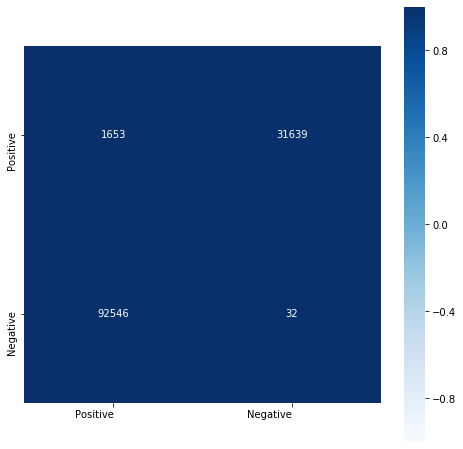

In [105]:
Ind_here = Metrics_CM_CK_IOU(valid_y,testing_image,images_HSVDOG)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


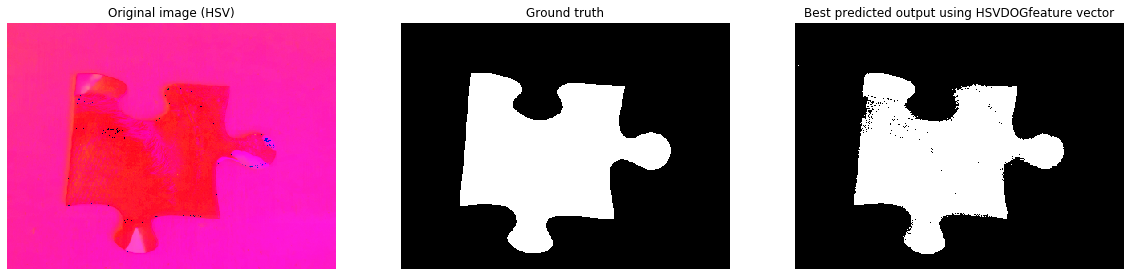

In [106]:
# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original image (HSV)")
plt.imshow(valid_X_HSV[rand_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[rand_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output using HSVDOGfeature vector")
plt.imshow(images_HSVDOG[Ind_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


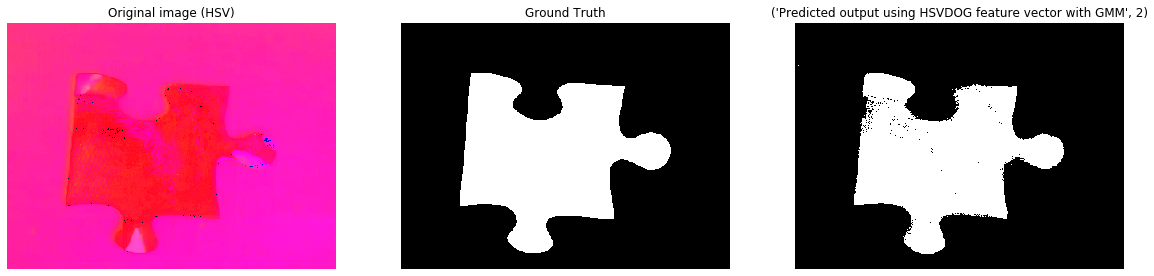

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


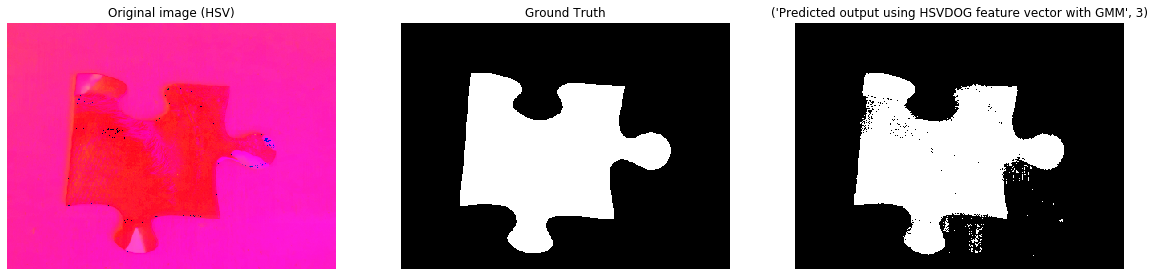

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


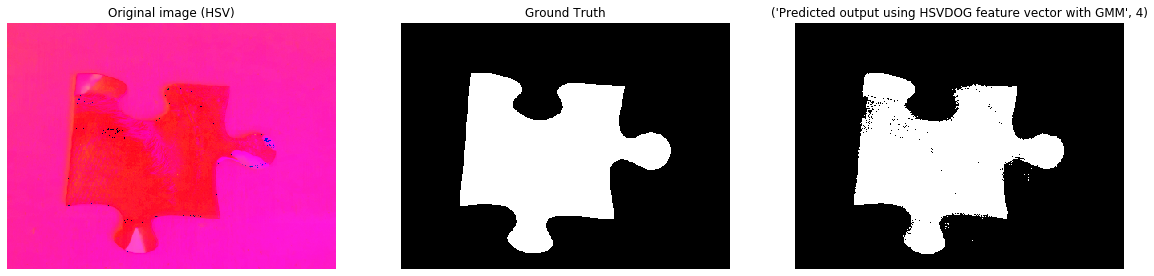

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


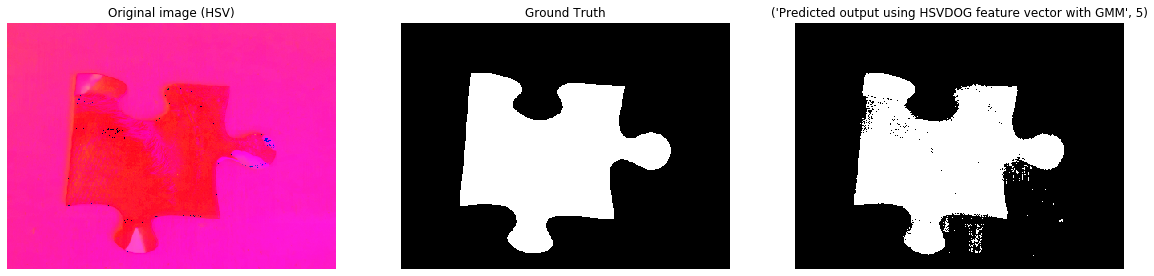

In [107]:
for i in range(len(images_HSVDOG)):
    # Spawn a new figure
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.title("Original image (HSV)")
    plt.imshow(valid_X_HSV[rand_image])
    # Turn off axis numbering
    plt.axis('off')

    # Show the second image
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(valid_y[rand_image])
    # Turn off the axis numbering
    plt.axis('off')
    
    plt.subplot(1,3,3)
    titles="Predicted output using HSVDOG feature vector with GMM",2+i
    plt.title(titles)
    plt.imshow(images_HSVDOG[i])
    # Turn off the axis numbering
    plt.axis('off')

    # Show the figure
    plt.grid(b=None)
    plt.show()

## Extra marks ( 6-fold cross validation)

#### 1.1 Splitting the dataset

###### 1.1.2 Data split for 6 fold cross validation

In [45]:
#6 fold data

#https://www.pluralsight.com/guides/validating-machine-learning-models-scikit-learn
#https://www.knowledgehut.com/blog/data-science/k-fold-cross-validation-in-ml

#this is the complete data with no slpit that will be used for the 6kfold validation
X_raw = np.asarray(images)#make this an array to be easy to use later one 
Y_raw = np.asarray(masks)# for the rest of the code is fine to use as list

In [ ]:
#sources:

#https://www.pluralsight.com/guides/validating-machine-learning-models-scikit-learn
#https://www.knowledgehut.com/blog/data-science/k-fold-cross-validation-in-ml


cv = KFold(n_splits=6, random_state=100)

testfold_X_RGB = []
testfold_Y_RGB = []
indicie_kfold = 1

for train_index, test_index in cv.split(X_raw): 
    
    #retrieve the index for the training and test data
    X_train, X_test, y_train, y_test = X_raw[train_index], X_raw[test_index], Y_raw[train_index], Y_raw[test_index]
    
    #append the data to be used for testing later on
    testfold_X_RGB.append(X_test)
    testfold_Y_RGB.append(y_test)
    
    #given the len of the data in the fold in this case all the images retrieve all the puzzle pixels for the training 
    puzzle_pixel_RGB_fold, background_pixel_RGB_fold, prior_RGB_fold = Puzzle_background_Pixels_one(len(X_train),X_train,y_train)
    
    print('Currently at Kfold iter',indicie_kfold)
    
    #fit the gmm as normaly done in the code
    gmms_puzzle = []
    gmms_background = []
    
    for i in range(4, 5):
        print('The number of gaussian for RGB implementation using puzzle pixels is:',i)
        pkl = open("gmm_puzzle"+str(i)+"-RGB_of_fold"+str(indicie_kfold)+".pickle","wb")
        gmm = GMM_scratch(puzzle_pixel_RGB_fold, i,0)#GMM with sklearn clustered centers
        gmm.fit()
        pickle.dump(gmm, pkl)
        gmms_puzzle.append(gmm)
        pkl.close()
        
    for i in range(4, 5):
        print('The number of gaussian for RGB implementation background pixels is:',i)
        pkl = open("gmm_background"+str(i)+"-RGB_of_fold"+str(indicie_kfold)+".pickle","wb")
        gmm = GMM_scratch(background_pixel_RGB_fold, i,0)#GMM with sklearn clustered centers
        gmm.fit()
        pickle.dump(gmm, pkl)
        gmms_background.append(gmm)
        pkl.close()
    
    indicie_kfold+=1

### Training section for DOG

In [ ]:
train_X_DoG = []
for i in range(len(X_raw)):
    test_DoG = cv2.filter2D(X_raw[i],-1,DoG(49,3,2))
    train_X_DoG.append(exposure.rescale_intensity(test_DoG))
    
X_DOG = np.asarray(train_X_DoG)

In [ ]:
cv = KFold(n_splits=6, random_state=100)

testfold_X_DOG = []
testfold_Y_DOG = []
priors_DOG = []
indicie_kfold = 1

for train_index, test_index in cv.split(X_DOG): 
    
    #retrieve the index for the training and test data
    X_train, X_test, y_train, y_test = X_DOG[train_index], X_DOG[test_index], Y_raw[train_index], Y_raw[test_index]
    
    #append the data to be used for testing later on
    testfold_X_DOG.append(X_test)
    testfold_Y_DOG.append(y_test)
    
    #retrieve the dog images(we are using X_DOG data)
    puzzle_pixel_DOG_fold, background_pixel_DOG_fold, prior_DOG_fold = Puzzle_background_Pixels_one(len(X_train),X_train,y_train)
    
    #retrieve the rgb images using same index as above(we are using the X_raw data array) 
    puzzle_pixel_RGB_fold, background_pixel_RGB_fold, prior_RGB_fold = Puzzle_background_Pixels_one(len(X_train),X_raw[train_index],Y_raw[train_index])
    

    #feature vector
    puzzle_pixel_RGBDOG = np.vstack((puzzle_pixel_RGB_fold, puzzle_pixel_DOG_fold))
    background_pixel_RGBDOG = np.vstack((background_pixel_RGB_fold, background_pixel_DOG_fold))
    prior_RGBDOG = prior_RGB_fold + prior_DOG_fold
    priors_DOG.append(prior_RGBDOG)
    
    print('Currently at Kfold iter',indicie_kfold)
    
    #fit the gmm as normaly done in the code
    gmms_puzzle = []
    gmms_background = []
    
    for i in range(4, 5):
        print('The number of gaussian for RGBDOG implementation using puzzle pixels is:',i)
        pkl = open("gmm_puzzle"+str(i)+"-RGBDOG_of_fold"+str(indicie_kfold)+".pickle","wb")
        gmm = GMM_scratch(puzzle_pixel_RGBDOG, i,0)#GMM with sklearn clustered centers
        gmm.fit()
        pickle.dump(gmm, pkl)
        gmms_puzzle.append(gmm)
        pkl.close()
        
    for i in range(4, 5):
        print('The number of gaussian for RGBDOG implementation background pixels is:',i)
        pkl = open("gmm_background"+str(i)+"-RGBDOG_of_fold"+str(indicie_kfold)+".pickle","wb")
        gmm = GMM_scratch(background_pixel_RGBDOG, i,0)#GMM with sklearn clustered centers
        gmm.fit()
        pickle.dump(gmm, pkl)
        gmms_background.append(gmm)
        pkl.close()
    
    indicie_kfold+=1

### Training section for HSV

In [ ]:
train_X_HSV = []

for i in range(len(X_raw)):
    train_HSV = cv2.cvtColor(X_raw[i], cv2.COLOR_RGB2HSV)
    train_X_HSV.append(train_HSV)
    
X_HSV = np.asarray(train_X_HSV)

In [ ]:
cv = KFold(n_splits=6, random_state=100)

testfold_X_HSV = []
testfold_Y_HSV = []
indicie_kfold = 1
priors_HSV = []

for train_index, test_index in cv.split(X_HSV): 
    
    #retrieve the index for the training and test data
    X_train, X_test, y_train, y_test = X_HSV[train_index], X_HSV[test_index], Y_raw[train_index], Y_raw[test_index]
    
    #append the data to be used for testing later on
    testfold_X_HSV.append(X_test)
    testfold_Y_HSV.append(y_test)
    
    #retrieve the HSV images(we are using X_HSV data)
    puzzle_pixel_HSV_fold, background_pixel_HSV_fold, prior_HSV_fold = Puzzle_background_Pixels_one(len(X_train),X_train,y_train)
    priors_HSV.append(prior_HSV_fold)
    
    print('Currently at Kfold iter',indicie_kfold)
    
    #fit the gmm as normaly done in the code
    gmms = []
    
    #fit the gmm as normaly done in the code
    gmms_puzzle = []
    gmms_background = []
    
    for i in range(4, 5):
        print('The number of gaussian for HSV implementation using puzzle pixels is:',i)
        pkl = open("gmm_puzzle"+str(i)+"-HSV_of_fold"+str(indicie_kfold)+".pickle","wb")
        gmm = GMM_scratch(puzzle_pixel_HSV_fold, i,0)#GMM with sklearn clustered centers
        gmm.fit()
        pickle.dump(gmm, pkl)
        gmms_puzzle.append(gmm)
        pkl.close()
        
    for i in range(4, 5):
        print('The number of gaussian for HSV implementation background pixels is:',i)
        pkl = open("gmm_background"+str(i)+"-HSV_of_fold"+str(indicie_kfold)+".pickle","wb")
        gmm = GMM_scratch(background_pixel_HSV_fold, i,0)#GMM with sklearn clustered centers
        gmm.fit()
        pickle.dump(gmm, pkl)
        gmms_background.append(gmm)
        pkl.close()
    
    indicie_kfold+=1

### Metrics

In [108]:
def Metrics_CM_CK_IOU_fold6(validation_image,index,images,components):
    '''
    Return the confusion matrix, the cohens kappa score and IOU (intersection over union)
    for only 4 probable masks.
    
    params: 
    - validation_image is the array containing the testing images
    - index of the image that was used to generate the probable images
    - image array containing all the image provided by the GMM (probable maks)
    
    '''
    #-------------------------------------------------Get Data------------------------------------------------------
    main_mask = validation_image[index]
    main_mask = main_mask.flatten()

    Prob_mask1 = images[0]
    Prob_mask1 = Prob_mask1.flatten()

    Prob_mask2 = images[1]
    Prob_mask2 = Prob_mask2.flatten()

    Prob_mask3 = images[2]
    Prob_mask3 = Prob_mask3.flatten()
    
    Prob_mask4 = images[3]
    Prob_mask4 = Prob_mask4.flatten()
    
    Prob_mask5 = images[4]
    Prob_mask5 = Prob_mask5.flatten()
    
    Prob_mask6 = images[5]
    Prob_mask6 = Prob_mask6.flatten()

    #----------------------------------------------Cohens Kappa--------------------------------------------------------
    cohens_kappa1 = cohen_kappa_score(main_mask, Prob_mask1)
    cohens_kappa2 = cohen_kappa_score(main_mask, Prob_mask2)
    cohens_kappa3 = cohen_kappa_score(main_mask, Prob_mask3)
    cohens_kappa4 = cohen_kappa_score(main_mask, Prob_mask4)
    cohens_kappa5 = cohen_kappa_score(main_mask, Prob_mask5)
    cohens_kappa6 = cohen_kappa_score(main_mask, Prob_mask6)
    
    my_scores = [cohens_kappa1,cohens_kappa2,cohens_kappa3,cohens_kappa4,cohens_kappa5,cohens_kappa6]
    cohens_kappa_final = np.mean(my_scores) 
    
    print('The average cohens kappa score for mask',index,'and GMM',components,'is:',cohens_kappa_final)
    #-----------------------------------------------F1 Score--------------------------------------------------------
    f1_score_1 = f1_score(main_mask, Prob_mask1)
    f1_score_2 = f1_score(main_mask, Prob_mask2)
    f1_score_3 = f1_score(main_mask, Prob_mask3)
    f1_score_4 = f1_score(main_mask, Prob_mask4)
    f1_score_5 = f1_score(main_mask, Prob_mask5)
    f1_score_6 = f1_score(main_mask, Prob_mask6)
    
    my_scores1 = [f1_score_1,f1_score_2,f1_score_3,f1_score_4,f1_score_5,f1_score_6]
    f1_score_final = np.mean(my_scores1) 
    
    print('The average f1 score for mask',index,'and GMM',components,'is:',f1_score_final)
    #------------------------------------------------IOU Section-------------------------------------------------------
    overlap = main_mask*Prob_mask1# Logical AND
    union = main_mask + Prob_mask1# Logical OR
    IOU1 = overlap.sum()/float(union.sum())           
    
    overlap = main_mask*Prob_mask2# Logical AND
    union = main_mask + Prob_mask2# Logical OR
    IOU2 = overlap.sum()/float(union.sum())     
    
    overlap = main_mask*Prob_mask3# Logical AND
    union = main_mask + Prob_mask3# Logical OR
    IOU3 = overlap.sum()/float(union.sum())     
    
    overlap = main_mask*Prob_mask4# Logical AND
    union = main_mask + Prob_mask4# Logical OR
    IOU4 = overlap.sum()/float(union.sum())     
    
    overlap = main_mask*Prob_mask5# Logical AND
    union = main_mask + Prob_mask5# Logical OR
    IOU5 = overlap.sum()/float(union.sum())     
    
    overlap = main_mask*Prob_mask6# Logical AND
    union = main_mask + Prob_mask6# Logical OR
    IOU6 = overlap.sum()/float(union.sum())     
    
    my_scores2 = [IOU1,IOU2,IOU3,IOU4,IOU5,IOU6]
    IOU_final = np.mean(my_scores2) 
    
    print('The average IOU score for mask',index,'and GMM',components,'is:',IOU_final)
    
    #------------------------------------------------Confusion Matrix-------------------------------------------------------
    model1 = confusion_matrix(main_mask, Prob_mask1)
    model2 = confusion_matrix(main_mask, Prob_mask2)
    model3 = confusion_matrix(main_mask, Prob_mask3)
    model4 = confusion_matrix(main_mask, Prob_mask4)
    model5 = confusion_matrix(main_mask, Prob_mask5)
    model6 = confusion_matrix(main_mask, Prob_mask6)
    
    CFM_final =  model1 + model2 + model3 + model4 + model5 + model6 
    print('The sum of confusion matricies for mask',index,'and GMM',components,'is:')
    
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(CFM_final, vmin=-1, vmax=1, center=0,cmap="Blues",square=True, annot=True, fmt=".0f")
    ax.set_ylim([0,2])
    
    ax.set_xticklabels(['Positive','Negative']) # set the labels to display at those ticks
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0,horizontalalignment='right');
    
    ax.set_yticklabels(['Negative','Positive']) # set the labels to display at those ticks
    ax.set_yticklabels(ax.get_yticklabels(),rotation=90,horizontalalignment='right');
    
    indexmax = my_scores2.index(max(my_scores2))
    return(indexmax)

In [109]:
def fold_inference(pickle_puzzle,pickle_background):
    '''
    This function is used to make inference on the fold validation section it simply takes params: 
    pickle_puzzle - this takes the pickles for the puzzle saved on the computer 
    pickle_background - this takes the pickles for the background saved on the computer 
    '''
    pickle_off0 = pickle_puzzle
    gmm_puzzle = pickle.load(pickle_off0) 

    pickle_off1 = pickle_background
    gmm_background = pickle.load(pickle_off1)

    index = numbr_image
    image, mask = (valid_X[index], valid_y[index])
    ##### The inference as specified in the question using the background and the puzzle pixels gmm
    likelihood1 = gmm_background.Proba(image) #probability of being background
    likelihood2 = gmm_puzzle.Proba(image) #probability of being foreground
    ##########  
    prior1 = prior_RGB
    prior2 = 1 - prior_RGB 
    #########   
    foreground_prior = prior2 * likelihood2
    Background_prior = foreground_prior + (prior1 * likelihood1)
    #########   
    prob = foreground_prior/Background_prior   
    ####### 
    prob[prob>0.5] = 1
    prob[prob<0.5] = 0

    return(prob)

This is 6 cross validation inference on GMM 1
The average cohens kappa score for mask 3 and GMM 1 is: 0.5792308746126753
The average f1 score for mask 3 and GMM 1 is: 0.6813568722516532
The average IOU score for mask 3 and GMM 1 is: 0.3406784361258266
The sum of confusion matricies for mask 3 and GMM 1 is:


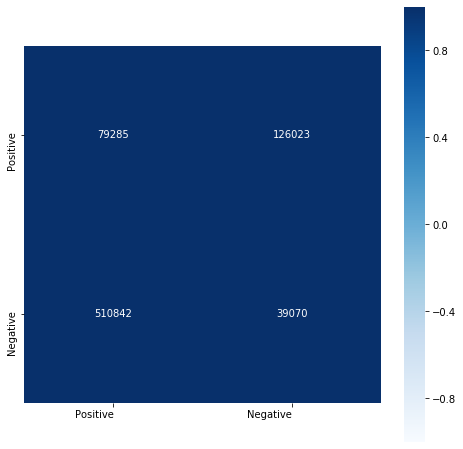

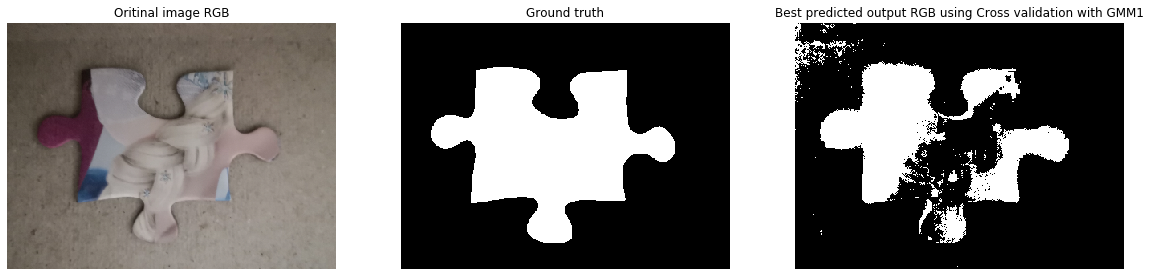

In [110]:
images_fold = []
numbr_image = random.randint(0, 6)
number_components = 1

print('This is 6 cross validation inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
index_here = Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Oritinal image RGB")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGB using Cross validation with GMM1")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

This is 6 cross validation using RGB inference on GMM 2
The average cohens kappa score for mask 3 and GMM 2 is: 0.6978221175884611
The average f1 score for mask 3 and GMM 2 is: 0.7736826364836257
The average IOU score for mask 3 and GMM 2 is: 0.3868413182418127
The sum of confusion matricies for mask 3 and GMM 2 is:


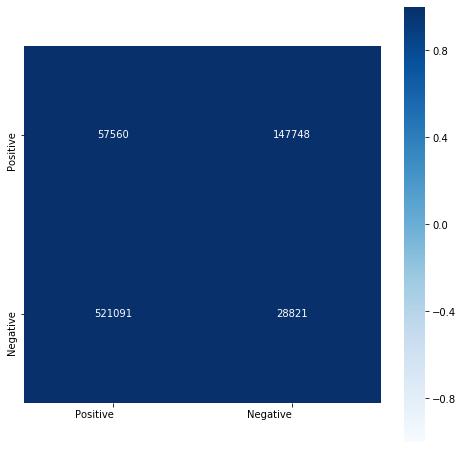

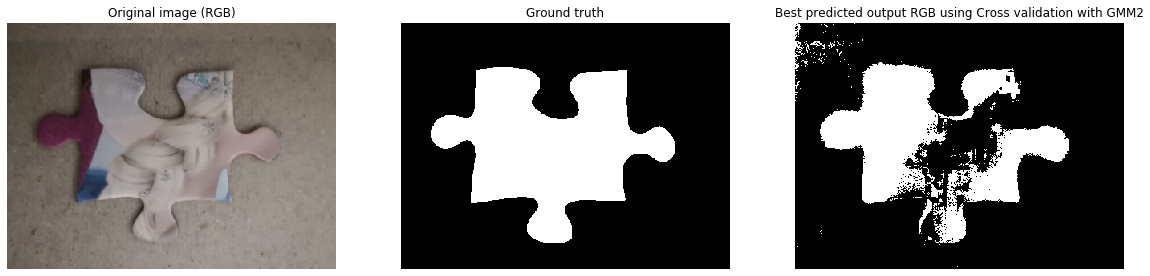

In [111]:
images_fold = []
number_components = 2

print('This is 6 cross validation using RGB inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original image (RGB)")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGB using Cross validation with GMM2")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

This is 6 cross validation using RGB inference on GMM 3
The average cohens kappa score for mask 3 and GMM 3 is: 0.772695966090612
The average f1 score for mask 3 and GMM 3 is: 0.828543645468709
The average IOU score for mask 3 and GMM 3 is: 0.4142718227343545
The sum of confusion matricies for mask 3 and GMM 3 is:


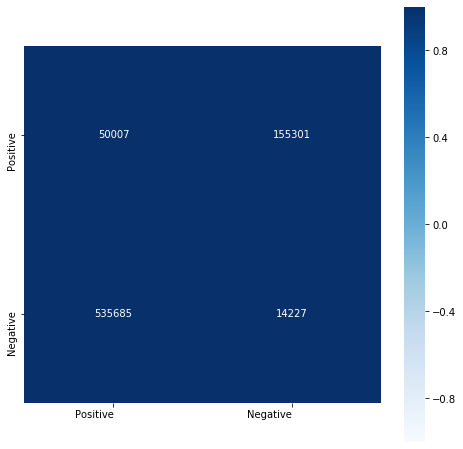

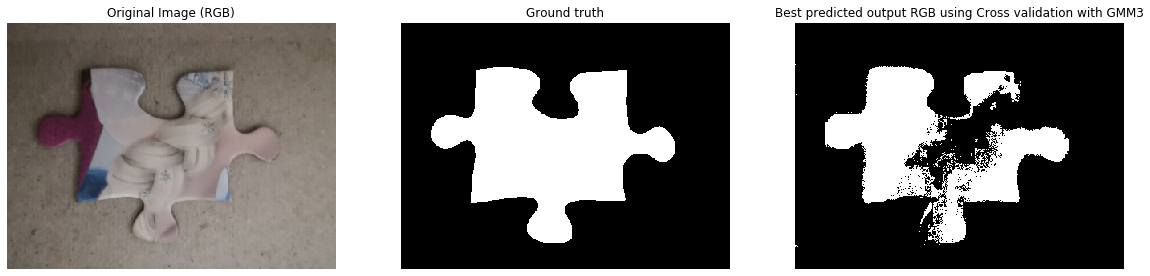

In [112]:
images_fold = []
number_components = 3

print('This is 6 cross validation using RGB inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original Image (RGB)")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGB using Cross validation with GMM3")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

This is 6 cross validation using RGB inference on GMM 4
The average cohens kappa score for mask 3 and GMM 4 is: 0.7996651805149894
The average f1 score for mask 3 and GMM 4 is: 0.8479764148239507
The average IOU score for mask 3 and GMM 4 is: 0.42398820741197535
The sum of confusion matricies for mask 3 and GMM 4 is:


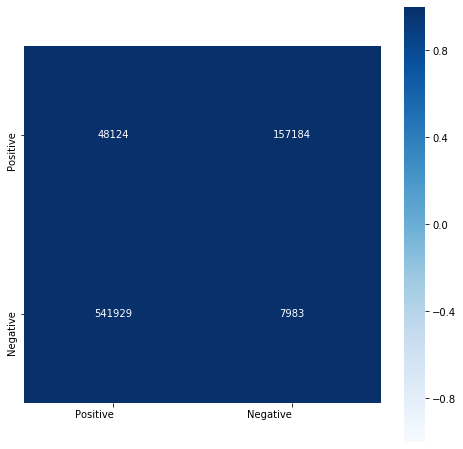

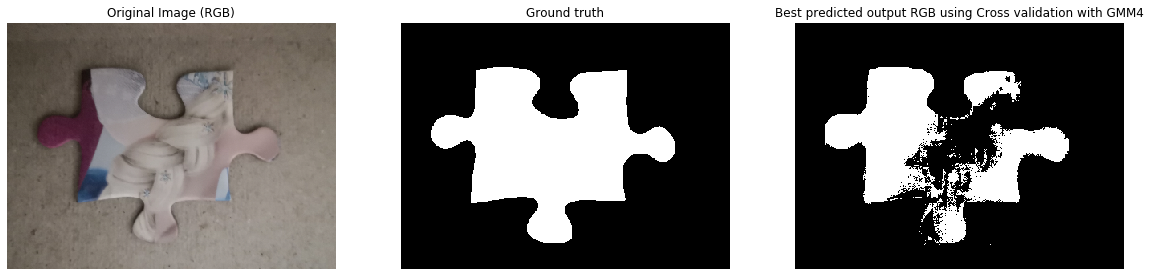

In [113]:
images_fold = []
number_components = 4

print('This is 6 cross validation using RGB inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGB_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original Image (RGB)")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGB using Cross validation with GMM4")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

This is 6 cross validation using RGBDOG inference on GMM 1
The average cohens kappa score for mask 3 and GMM 1 is: 0.5019637729067915
The average f1 score for mask 3 and GMM 1 is: 0.5811723112731999
The average IOU score for mask 3 and GMM 1 is: 0.2905861556365999
The sum of confusion matricies for mask 3 and GMM 1 is:


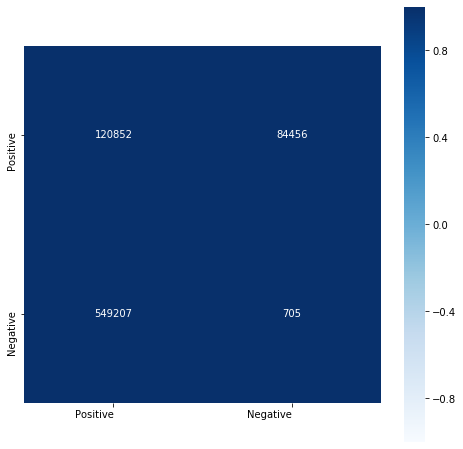

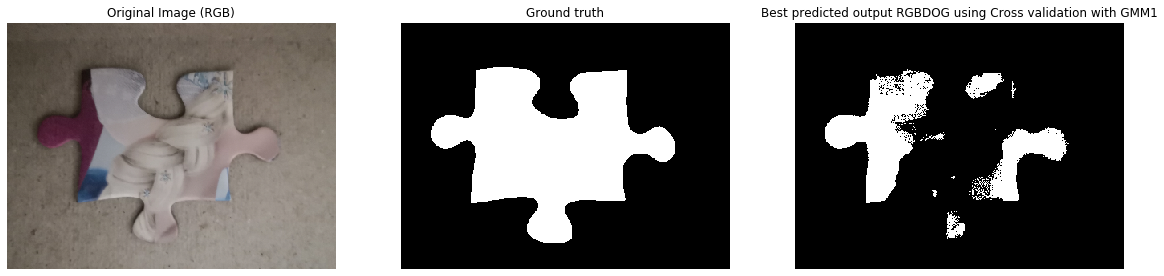

In [114]:
images_fold = []
number_components = 1

print('This is 6 cross validation using RGBDOG inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGBDOG_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGBDOG_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original Image (RGB)")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGBDOG using Cross validation with GMM1")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

This is 6 cross validation using RGBDOG inference on GMM 2
The average cohens kappa score for mask 3 and GMM 2 is: 0.6077847065770946
The average f1 score for mask 3 and GMM 2 is: 0.6814460186617995
The average IOU score for mask 3 and GMM 2 is: 0.3407230093308998
The sum of confusion matricies for mask 3 and GMM 2 is:


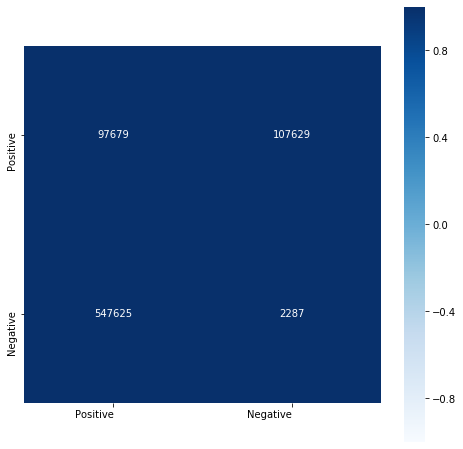

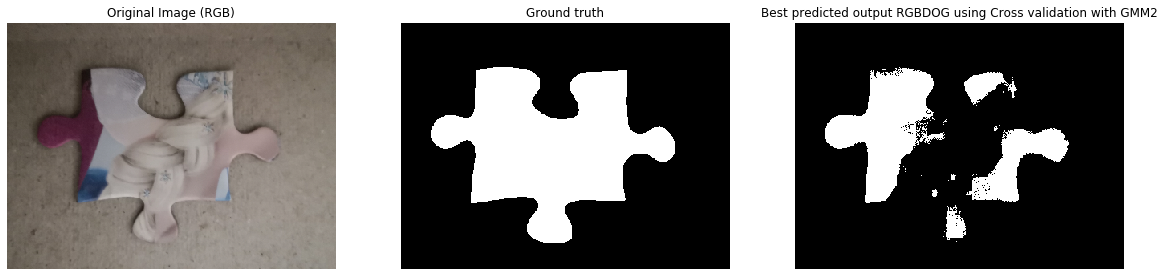

In [115]:
images_fold = []
number_components = 2

print('This is 6 cross validation using RGBDOG inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGBDOG_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGBDOG_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original Image (RGB)")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGBDOG using Cross validation with GMM2")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()

This is 6 cross validation using RGBDOG inference on GMM 3
The average cohens kappa score for mask 3 and GMM 3 is: 0.5678145604830849
The average f1 score for mask 3 and GMM 3 is: 0.6905998599976896
The average IOU score for mask 3 and GMM 3 is: 0.3452999299988447
The sum of confusion matricies for mask 3 and GMM 3 is:


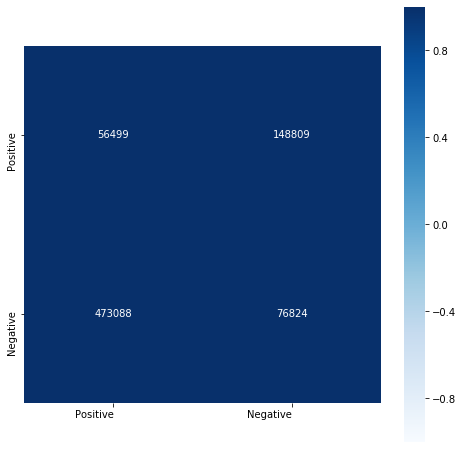

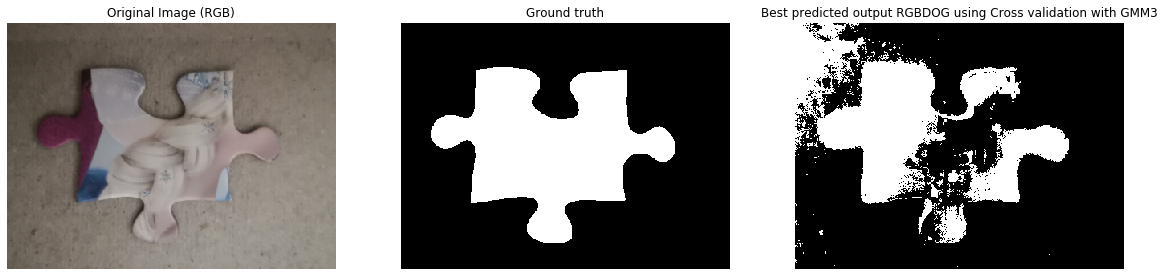

In [116]:
images_fold = []
number_components = 3

print('This is 6 cross validation using RGBDOG inference on GMM',number_components)
for i in range(1,7):  
    pickle_puzzle1 = open("foldtest/gmm_puzzle"+str(number_components)+"-RGBDOG_of_fold"+str(i)+".pickle","rb")
    pickle_background1 = open("foldtest/gmm_background"+str(number_components)+"-RGBDOG_of_fold"+str(i)+".pickle","rb")
    images_fold.append(fold_inference(pickle_puzzle1,pickle_background1)) 
    
Metrics_CM_CK_IOU_fold6(valid_y,numbr_image,images_fold,number_components)

# Spawn a new figure
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.title("Original Image (RGB)")
plt.imshow(valid_X[numbr_image])
# Turn off axis numbering
plt.axis('off')

# Show the second image
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(valid_y[numbr_image])
# Turn off the axis numbering
plt.axis('off')

    
plt.subplot(1,3,3)
plt.title("Best predicted output RGBDOG using Cross validation with GMM3")
plt.imshow(images_fold[index_here])
# Turn off the axis numbering
plt.axis('off')
    
# Show the figure
plt.grid(b=None)
plt.show()